<a href="https://colab.research.google.com/github/dhanmoti/ml-exercise/blob/smu-fnce685-project/SMU_FNCE685_G2_PD_Prediction_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Define the Problem & **Objectives**
## Objective
* **Static PD Model**: Predicts probability of default (PD) at loan origination based on borrower characteristics at application.

* **Dynamic PD Model**: Adjusts PD over time by incorporating loan performance trends and changing borrower behavior.

### Hypothesis
A dynamic PD model provides better predictions by adapting to changing borrower conditions, whereas a static model can only be used at loan origination stage.

### Data source
[Kaggle](https://www.kaggle.com/competitions/loan-default-pred/data?select=loan_test.csv)


### Feature selection
* Domain based
* LASSO
* XGBRegressor

# Install & Import

In [ ]:
# Install packages if required
# !pip install -q kaggle
# !pip install xgboost catboost
# !pip install ace_tools
# !pip install ydata_profiling swifter
# !pip install pycaret[full]
# !pip install scikit-learn-intelex
# !pip install fastapi[all] mlflow pyngrok

In [ ]:
# Import
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
import warnings
warnings.filterwarnings('ignore')


In [ ]:
 # Setting up kaggle
from google.colab import files

# files.upload()
# ! mkdir ~/.kaggle

# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# # Download Kaggle data
# ! kaggle competitions download -c loan-default-pred
# !unzip loan-default-pred.zip

# Reusable Functions

In [ ]:
def plot_correlation_heatmap(df, annot=False, figsize=(12, 8), cmap="coolwarm", linewidths=0.5, columns_subset=None):
    """
    Plots a heatmap of the correlation matrix for the given DataFrame.

    Parameters:
        df (pandas.DataFrame): The input DataFrame.
        annot (bool): Whether to display correlation coefficients.
                      Disabling it (annot=False) can speed up rendering.
        figsize (tuple): Size of the figure.
        cmap (str): Colormap.
        linewidths (float): Width of the lines that will divide each cell.
        columns_subset (list or None): If provided, only these columns will be used to compute the correlation.

    Returns:
        None: Displays the heatmap.
    """
    # If a subset of columns is provided, use it; otherwise, select numeric columns.
    if columns_subset is not None:
        data = df[columns_subset]
    else:
        data = df.select_dtypes(include=[np.number])

    # Compute the correlation matrix.
    corr_matrix = data.corr()

    # Create the heatmap.
    plt.figure(figsize=figsize)
    sns.heatmap(corr_matrix, annot=annot, fmt=".2f", cmap=cmap, linewidths=linewidths)
    plt.title("Feature Correlation Heatmap")
    plt.show()

In [ ]:
import numpy as np
import pandas as pd

def drop_highly_correlated_features(df, threshold=0.75):
    """
    Drops features from the DataFrame that are highly correlated with others using a vectorized approach.

    Parameters:
        df (pandas.DataFrame): The input DataFrame.
        threshold (float): The correlation threshold above which a feature is dropped.
                           (Default is 0.75)

    Returns:
        new_df (pandas.DataFrame): A new DataFrame with highly correlated features removed.
        dropped_features (list): A list of the feature names that were dropped.
    """
    # Compute the correlation matrix and take the absolute value
    corr_matrix = df.corr().abs()

    # Create a mask for the upper triangle (excluding the diagonal)
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Identify columns to drop: any column with a correlation value greater than the threshold
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

    # Drop these columns from the DataFrame
    new_df = df.drop(columns=to_drop)

    return new_df, to_drop

In [ ]:
def preprocess_dataframe(df):
    """
    Preprocess the DataFrame by performing the following:
      1. Drop unnecessary columns.
      2. Convert interest rate ('int_rate') from a percentage string to float.
      3. Convert date columns ('issue_d' and 'last_pymnt_d') to datetime.
      4. Label encode specified ordinal columns.
      5. One-hot encode any remaining categorical columns.

    Parameters:
      df (pandas.DataFrame): The input DataFrame.

    Returns:
      df_encoded (pandas.DataFrame): The preprocessed DataFrame.
      label_encoders (dict): Dictionary of fitted label encoders for ordinal columns.
    """
    # Work on a copy to avoid modifying the original DataFrame.
    df_processed = df.copy()

    # 1. Drop unnecessary columns (ignore if any are missing).
    cols_to_drop = ['id', 'member_id', 'url', 'desc', 'title', 'emp_title', 'zip_code', 'mths_since_last_record', 'mths_since_last_delinq', 'addr_state']
    df_processed.drop(columns=cols_to_drop, errors='ignore', inplace=True)

    # 2. Convert interest rate from percentage string to float.
    if 'int_rate' in df_processed.columns:
        df_processed['int_rate'] = df_processed['int_rate'].str.rstrip('%').astype(float)
    #2.1
    if 'revol_util' in df_processed.columns:
        df_processed['revol_util'] = df_processed['revol_util'].str.rstrip('%').astype(float)

    # 3. Convert date columns to datetime objects.
    date_columns = {
         'issue_d': '%b-%y',
         'last_pymnt_d': '%b-%y',
         'last_credit_pull_d': '%b-%y',
         'earliest_cr_line': '%b-%y'
    }
    for col, date_format in date_columns.items():
        if col in df_processed.columns:
            df_processed[col] = pd.to_datetime(df_processed[col], format=date_format)

    # 3.1 Convert date to ordinal numerical data
    df_processed = convert_datetime_columns(df_processed, method='ordinal')


    # 4. Label encode specified ordinal columns.
    ordinal_columns = ['term', 'grade', 'sub_grade', 'emp_length']
    label_encoders = {}
    for col in ordinal_columns:
        if col in df_processed.columns:
            le = LabelEncoder()
            df_processed[col] = le.fit_transform(df_processed[col])
            label_encoders[col] = le

    # 5. Identify any remaining categorical columns and apply one-hot encoding.
    categorical_cols = df_processed.select_dtypes(include=['object']).columns
    print("Categorical Columns for one-hot encoding:", list(categorical_cols))
    df_encoded = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)

    # Optional: Check conversion of date columns if they exist.
    if 'issue_d' in df_encoded.columns and 'last_pymnt_d' in df_encoded.columns:
        print("Date conversion check:")
        print(df_encoded[['issue_d', 'last_pymnt_d']].head())

    return df_encoded, label_encoders

# Example usage:
# df = pd.read_csv('your_dataset.csv')
# df_preprocessed, encoders = preprocess_dataframe(df)
# df_preprocessed.head()


In [ ]:
import pandas as pd

def handle_missing_values(df, method='fill', numeric_strategy='median', categorical_strategy='mode'):
    """
    Handles missing values in the DataFrame.

    Parameters:
        df (pandas.DataFrame): The input DataFrame.
        method (str): Method to handle missing values. Options:
                      'fill' (default) to fill missing values,
                      'drop' to drop rows with missing values.
        numeric_strategy (str): Strategy for numeric columns when method='fill'.
                                Options: 'median' (default) or 'mean'.
        categorical_strategy (str): Strategy for categorical columns when method='fill'.
                                    Options: 'mode' (default). If another value is provided,
                                    missing values will be filled with the string "Missing".

    Returns:
        pandas.DataFrame: A new DataFrame with missing values handled.
    """
    df_handled = df.copy()

    if method == 'fill':
        # Fill numeric columns.
        numeric_cols = df_handled.select_dtypes(include=['number']).columns
        for col in numeric_cols:
            if numeric_strategy == 'median':
                df_handled[col].fillna(df_handled[col].median(), inplace=True)
            elif numeric_strategy == 'mean':
                df_handled[col].fillna(df_handled[col].mean(), inplace=True)
            else:
                raise ValueError("Invalid numeric_strategy. Use 'median' or 'mean'.")

        # Fill categorical columns.
        categorical_cols = df_handled.select_dtypes(include=['object']).columns
        for col in categorical_cols:
            if categorical_strategy == 'mode':
                # Use the most frequent value.
                df_handled[col].fillna(df_handled[col].mode()[0], inplace=True)
            else:
                # Fill with a custom string if desired.
                df_handled[col].fillna("Missing", inplace=True)

    elif method == 'drop':
        df_handled.dropna(inplace=True)
    else:
        raise ValueError("Invalid method. Use 'fill' or 'drop'.")

    return df_handled

# Example usage:
# df = pd.read_csv('your_dataset.csv')
# df_clean = handle_missing_values(df, method='fill', numeric_strategy='median', categorical_strategy='mode')
# df_clean.info()


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error

def run_lasso_feature_selection(df, target, test_size=0.2, random_state=42):
    """
    Splits the dataset, applies LassoCV for feature selection and regression,
    prints and returns the selected features and test set performance.

    Parameters:
        df (pandas.DataFrame): Input DataFrame with features and target.
        target (str): Name of the target column.
        test_size (float): Fraction of data to use as test set (default is 0.2).
        random_state (int): Random seed for reproducibility (default is 42).

    Returns:
        lasso_cv (LassoCV): The fitted LassoCV model.
        selected_features (list): List of feature names with non-zero coefficients.
        mse (float): Mean Squared Error on the test set.
    """
    # Separate features and target
    X = df.drop(columns=[target])
    y = df[target]

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=test_size,
                                                        random_state=random_state)

    # Standardize Features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)


    # Apply Lasso with cross-validation to find the optimal regularization parameter
    alphas = np.logspace(-5, 0, 200)  # Experiment with a wider range of alphas
    lasso_cv = LassoCV(alphas=alphas, cv=10, random_state=random_state)
    lasso_cv.fit(X_train, y_train)

    # Identify features with non-zero coefficients
    selected_features = X.columns[lasso_cv.coef_ != 0]
    print("Selected features:", list(selected_features))

    # Evaluate performance on the test set
    y_pred = lasso_cv.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error:", mse)

    return lasso_cv, list(selected_features), mse

# Example usage:
# df = pd.read_csv('your_dataset.csv')
# model, features, error = run_lasso_feature_selection(df, target='target')


In [ ]:
import pandas as pd

def convert_datetime_columns(df, method='ordinal'):
    """
    Convert all datetime columns in a DataFrame to numeric values.

    Parameters:
        df (pandas.DataFrame): The input DataFrame.
        method (str): Conversion method. Options:
                      'ordinal' - converts to ordinal (days count) using toordinal().
                      'unix' - converts to Unix timestamp (seconds since epoch).

    Returns:
        df (pandas.DataFrame): The DataFrame with datetime columns converted to numeric values.
    """
    datetime_cols = df.select_dtypes(include=['datetime64[ns]']).columns
    for col in datetime_cols:
        if method == 'ordinal':
            # Convert each datetime to its ordinal if not null; otherwise, return None
            df[col] = df[col].apply(lambda x: x.toordinal() if pd.notnull(x) else None)
        elif method == 'unix':
            # Convert each datetime to a Unix timestamp if not null; otherwise, return None
            df[col] = df[col].apply(lambda x: int(x.timestamp()) if pd.notnull(x) else None)
        else:
            raise ValueError("Invalid method. Choose 'ordinal' or 'unix'.")
    return df

# Example usage:
# Assuming X_train and X_test are your training and testing DataFrames containing datetime columns:
# X_train = convert_datetime_columns(X_train, method='ordinal')
# X_test = convert_datetime_columns(X_test, method='ordinal')


In [ ]:
def standardize_numerical_features(X):
  # Scale numerical features [split first. do it on train set]
  scaler = StandardScaler()
  numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns
  X[numeric_columns] = scaler.fit_transform(X[numeric_columns])
  return X

# Load

In [ ]:
# Load dataset
df_train_raw = pd.read_csv("/content/loan_train.csv")
df_train = df_train_raw.copy()

## Check Data Types & Convert Columns if Needed


In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27003 entries, 0 to 27002
Data columns (total 47 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       27003 non-null  int64  
 1   member_id                27003 non-null  int64  
 2   loan_amnt                27003 non-null  int64  
 3   funded_amnt              27003 non-null  int64  
 4   funded_amnt_inv          27003 non-null  float64
 5   term                     27003 non-null  object 
 6   int_rate                 27003 non-null  object 
 7   installment              27003 non-null  float64
 8   grade                    27003 non-null  object 
 9   sub_grade                27003 non-null  object 
 10  emp_title                25321 non-null  object 
 11  emp_length               26273 non-null  object 
 12  home_ownership           27003 non-null  object 
 13  annual_inc               27003 non-null  float64
 14  verification_status   

In [ ]:
df_train.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,pub_rec_bankruptcies
0,540179,697401,10000,10000,9975.0,36 months,13.23%,338.05,C,C1,...,11943.68,10000.00,1973.61,0.0,0.00,0.0,Sep-12,3536.63,Mar-14,0.0
1,585434,752191,14000,14000,13775.0,36 months,7.88%,437.94,A,A5,...,15470.79,14000.00,1723.48,0.0,0.00,0.0,May-13,2603.31,Jan-16,0.0
2,457736,569298,9475,9475,9475.0,36 months,8.94%,301.04,A,A5,...,10472.09,9475.00,997.09,0.0,0.00,0.0,May-11,5365.49,Aug-15,0.0
3,734349,930860,4000,4000,4000.0,36 months,7.29%,124.04,A,A4,...,4425.26,4000.00,425.26,0.0,0.00,0.0,Jul-13,1336.22,May-15,0.0
4,1050080,1281522,3600,3600,3600.0,36 months,6.62%,110.54,A,A2,...,2321.34,2004.17,306.88,0.0,10.29,0.0,Sep-13,110.54,May-16,0.0


In [ ]:
missing_values = df_train.isnull().sum()
print(missing_values[missing_values > 0])

emp_title                  1682
emp_length                  730
desc                       8779
title                         9
mths_since_last_delinq    17395
mths_since_last_record    25065
revol_util                   35
last_pymnt_d                 51
last_credit_pull_d            1
pub_rec_bankruptcies        503
dtype: int64


##### Before remove 'recoveries' feature based on XGBRegressor SHAP waterfall results
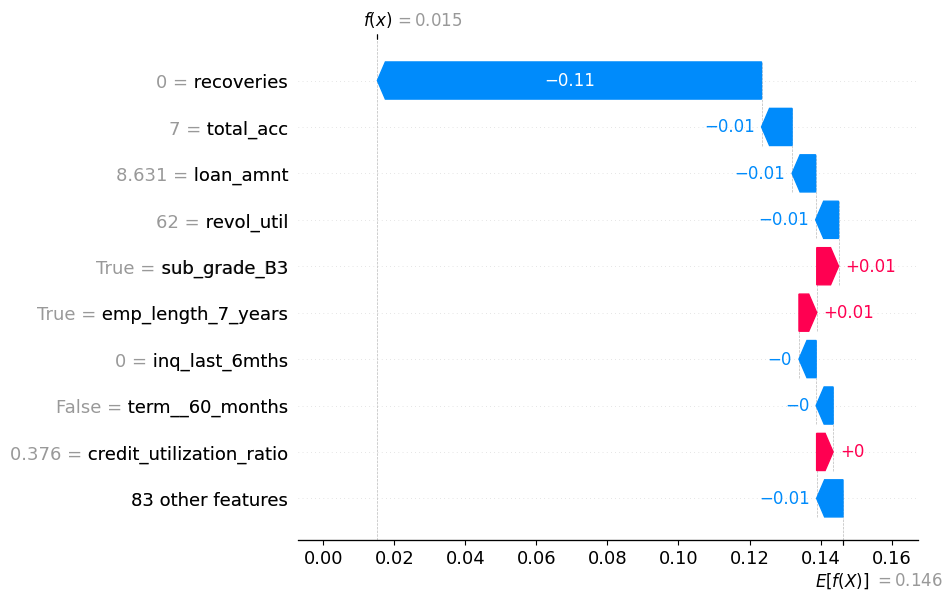

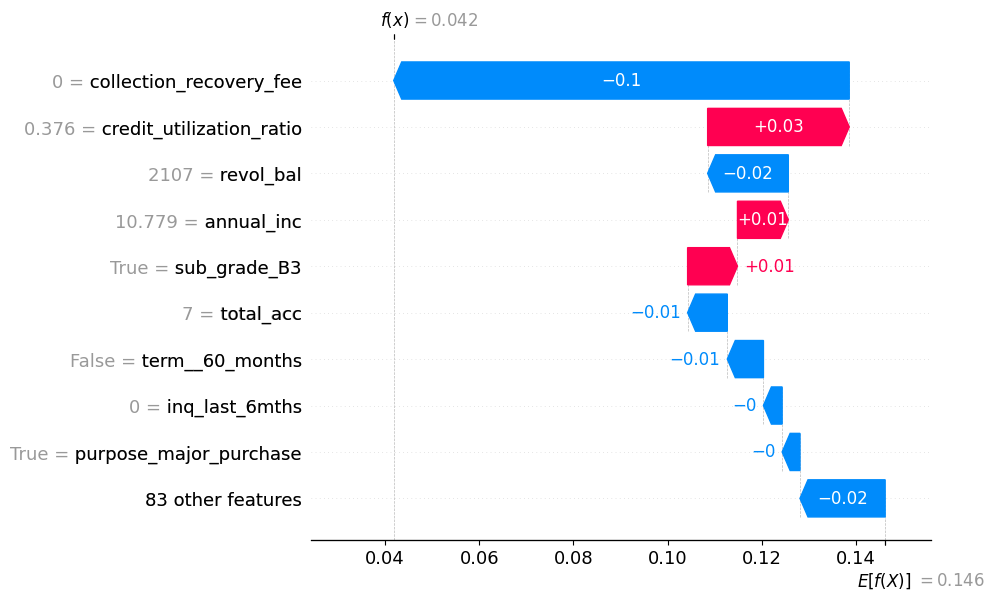

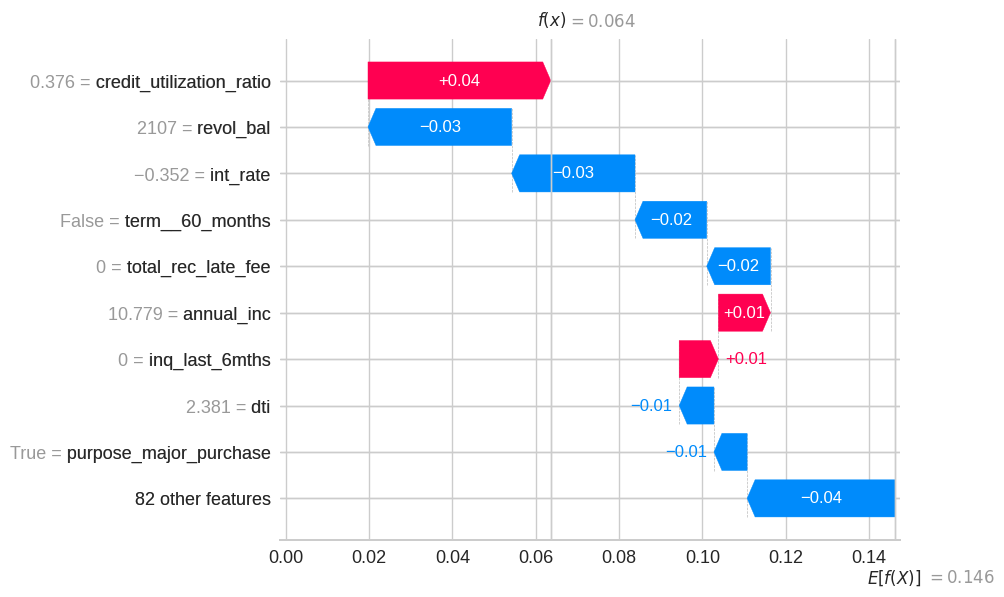

In [ ]:
# df_preprocessed_train, encoders = preprocess_dataframe(df_train)
 # Work on a copy to avoid modifying the original DataFrame.
df_processed = df_train.copy()

# 1. Drop unnecessary columns (ignore if any are missing).
# 'mths_since_last_record', 'mths_since_last_delinq' dropped due to high missing values > 60%
# 'addr_state' dropped due to high number of cols after one-hot encoding
# 'issue_d', 'last_pymnt_d' and 'last_pymnt_amnt' might introduce data leakage because these info will be available only after default
# 'last_credit_pull_d' -> If this column reflects a credit inquiry date made after a significant loan event (e.g., a default or a restructuring), it might leak future information.
# 'recoveries' and 'collection_recovery_fee' -> suspect data leakage after analysing using SHAP where this features standout
# 'int_rate' -> Interest Rate on the loan. suspect data leakage after analysing using SHAP where this features standout
cols_to_drop = [
    'id',
    'member_id',
    'url',
    'desc',
    'title',
    'emp_title',
    'zip_code',
    'addr_state',
    'mths_since_last_record',
    'mths_since_last_delinq', # [todo] instead of dropping, put -1.
    'last_pymnt_d',
    'last_pymnt_amnt',
    'last_credit_pull_d',
    'issue_d',
    'recoveries',
    'collection_recovery_fee',
    'int_rate'
]
df_processed.drop(columns=cols_to_drop, errors='ignore', inplace=True)

# 2. Convert interest rate from percentage string to float.
if 'int_rate' in df_processed.columns:
    df_processed['int_rate'] = df_processed['int_rate'].str.rstrip('%').astype(float)
#2.1 Convert revol_util from percentage string to float.
if 'revol_util' in df_processed.columns:
    df_processed['revol_util'] = df_processed['revol_util'].str.rstrip('%').astype(float)

# 3. Convert date columns to datetime objects.
date_columns = {
      #'issue_d': '%b-%y',
     # 'last_pymnt_d': '%b-%y',
      'last_credit_pull_d': '%b-%y',
      'earliest_cr_line': '%b-%y'
}
for col, date_format in date_columns.items():
    if col in df_processed.columns:
        df_processed[col] = pd.to_datetime(df_processed[col], format=date_format)

# fianl_df_proceed = df_processed.copy()

In [ ]:
# df_processed.to_csv('df_processed.csv', index=False)

In [ ]:

# 3.1 Convert date to ordinal numerical data
datetime_cols = df_processed.select_dtypes(include=['datetime64[ns]']).columns
for col in datetime_cols:
    df_processed[col] = df_processed[col].apply(lambda x: x.toordinal() if pd.notnull(x) else None)


# 4. Label encode specified ordinal columns.
ordinal_columns = ['term', 'grade', 'sub_grade', 'emp_length']
label_encoders = {}
for col in ordinal_columns:
    if col in df_processed.columns:
        le = LabelEncoder()
        df_processed[col] = le.fit_transform(df_processed[col])
        label_encoders[col] = le

# 5. Identify any remaining categorical columns and apply one-hot encoding.
categorical_cols = df_processed.select_dtypes(include=['object']).columns
print("Categorical Columns for one-hot encoding:", list(categorical_cols))
df_encoded = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)


df_encoded.head()

Categorical Columns for one-hot encoding: ['home_ownership', 'verification_status', 'purpose']


,loan_amnt,funded_amnt,funded_amnt_inv,term,installment,grade,sub_grade,emp_length,annual_inc,loan_status,...,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding
0,10000,10000,9975.0,0,338.05,2,10,4,37000.0,0,...,False,False,False,False,False,False,False,False,False,False
1,14000,14000,13775.0,0,437.94,0,4,10,105000.0,0,...,False,False,False,False,False,False,False,False,False,False
2,9475,9475,9475.0,0,301.04,0,4,9,27000.0,0,...,False,False,False,False,False,False,False,False,False,False
3,4000,4000,4000.0,0,124.04,0,3,1,35000.0,0,...,False,False,False,False,False,False,False,False,False,False
4,3600,3600,3600.0,0,110.54,0,1,0,60000.0,1,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27003 entries, 0 to 27002
Data columns (total 46 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   loan_amnt                            27003 non-null  int64  
 1   funded_amnt                          27003 non-null  int64  
 2   funded_amnt_inv                      27003 non-null  float64
 3   term                                 27003 non-null  int64  
 4   installment                          27003 non-null  float64
 5   grade                                27003 non-null  int64  
 6   sub_grade                            27003 non-null  int64  
 7   emp_length                           27003 non-null  int64  
 8   annual_inc                           27003 non-null  float64
 9   loan_status                          27003 non-null  int64  
 10  dti                                  27003 non-null  float64
 11  delinq_2yrs                 

# Cleaning data

In [ ]:
# Calculate percentage of missing values for each column
missing_percent = df_encoded.isnull().mean() * 100

# Create a DataFrame to display the results neatly
missing_table = pd.DataFrame({
    'Column': missing_percent.index,
    'Missing Percentage': missing_percent.values
})

# Sort the table by missing percentage (highest first) and display it
missing_table.sort_values(by='Missing Percentage', ascending=False, inplace=True)
print(missing_table)

                                 Column  Missing Percentage
26                 pub_rec_bankruptcies            1.862756
17                           revol_util            0.129615
0                             loan_amnt            0.000000
34           purpose_debt_consolidation            0.000000
27                  home_ownership_NONE            0.000000
28                 home_ownership_OTHER            0.000000
29                   home_ownership_OWN            0.000000
30                  home_ownership_RENT            0.000000
31  verification_status_Source Verified            0.000000
32         verification_status_Verified            0.000000
33                  purpose_credit_card            0.000000
35                  purpose_educational            0.000000
24                        total_rec_int            0.000000
36             purpose_home_improvement            0.000000
37                        purpose_house            0.000000
38               purpose_major_purchase 

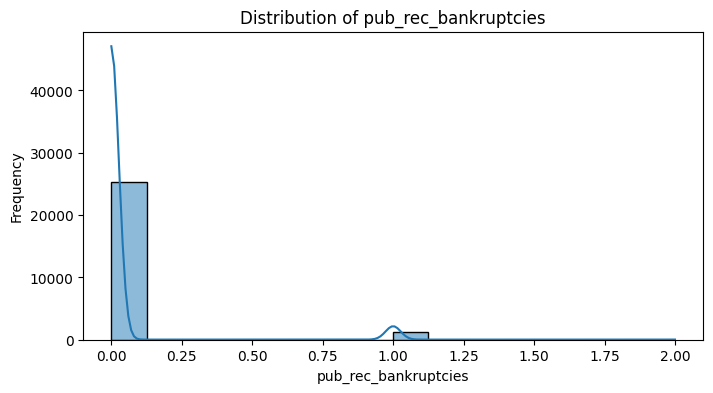

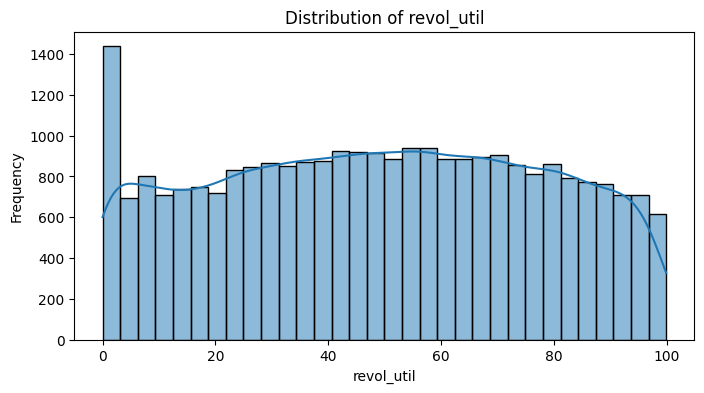

In [ ]:
# Visualise numeric columns
numeric_cols = ['pub_rec_bankruptcies', 'revol_util']
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_encoded[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [ ]:
# [ToDo] do it only in train test only
# Handle missing values. Drop if it is not normal distribution
df_encoded['pub_rec_bankruptcies'].fillna(df_encoded[col].mode(), inplace=True)
# df_encoded['last_pymnt_d'].fillna(df_encoded[col].median(), inplace=True)
df_encoded['revol_util'].fillna(df_encoded[col].mean(), inplace=True)

In [ ]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27003 entries, 0 to 27002
Data columns (total 46 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   loan_amnt                            27003 non-null  int64  
 1   funded_amnt                          27003 non-null  int64  
 2   funded_amnt_inv                      27003 non-null  float64
 3   term                                 27003 non-null  int64  
 4   installment                          27003 non-null  float64
 5   grade                                27003 non-null  int64  
 6   sub_grade                            27003 non-null  int64  
 7   emp_length                           27003 non-null  int64  
 8   annual_inc                           27003 non-null  float64
 9   loan_status                          27003 non-null  int64  
 10  dti                                  27003 non-null  float64
 11  delinq_2yrs                 

## Display correlation matrix



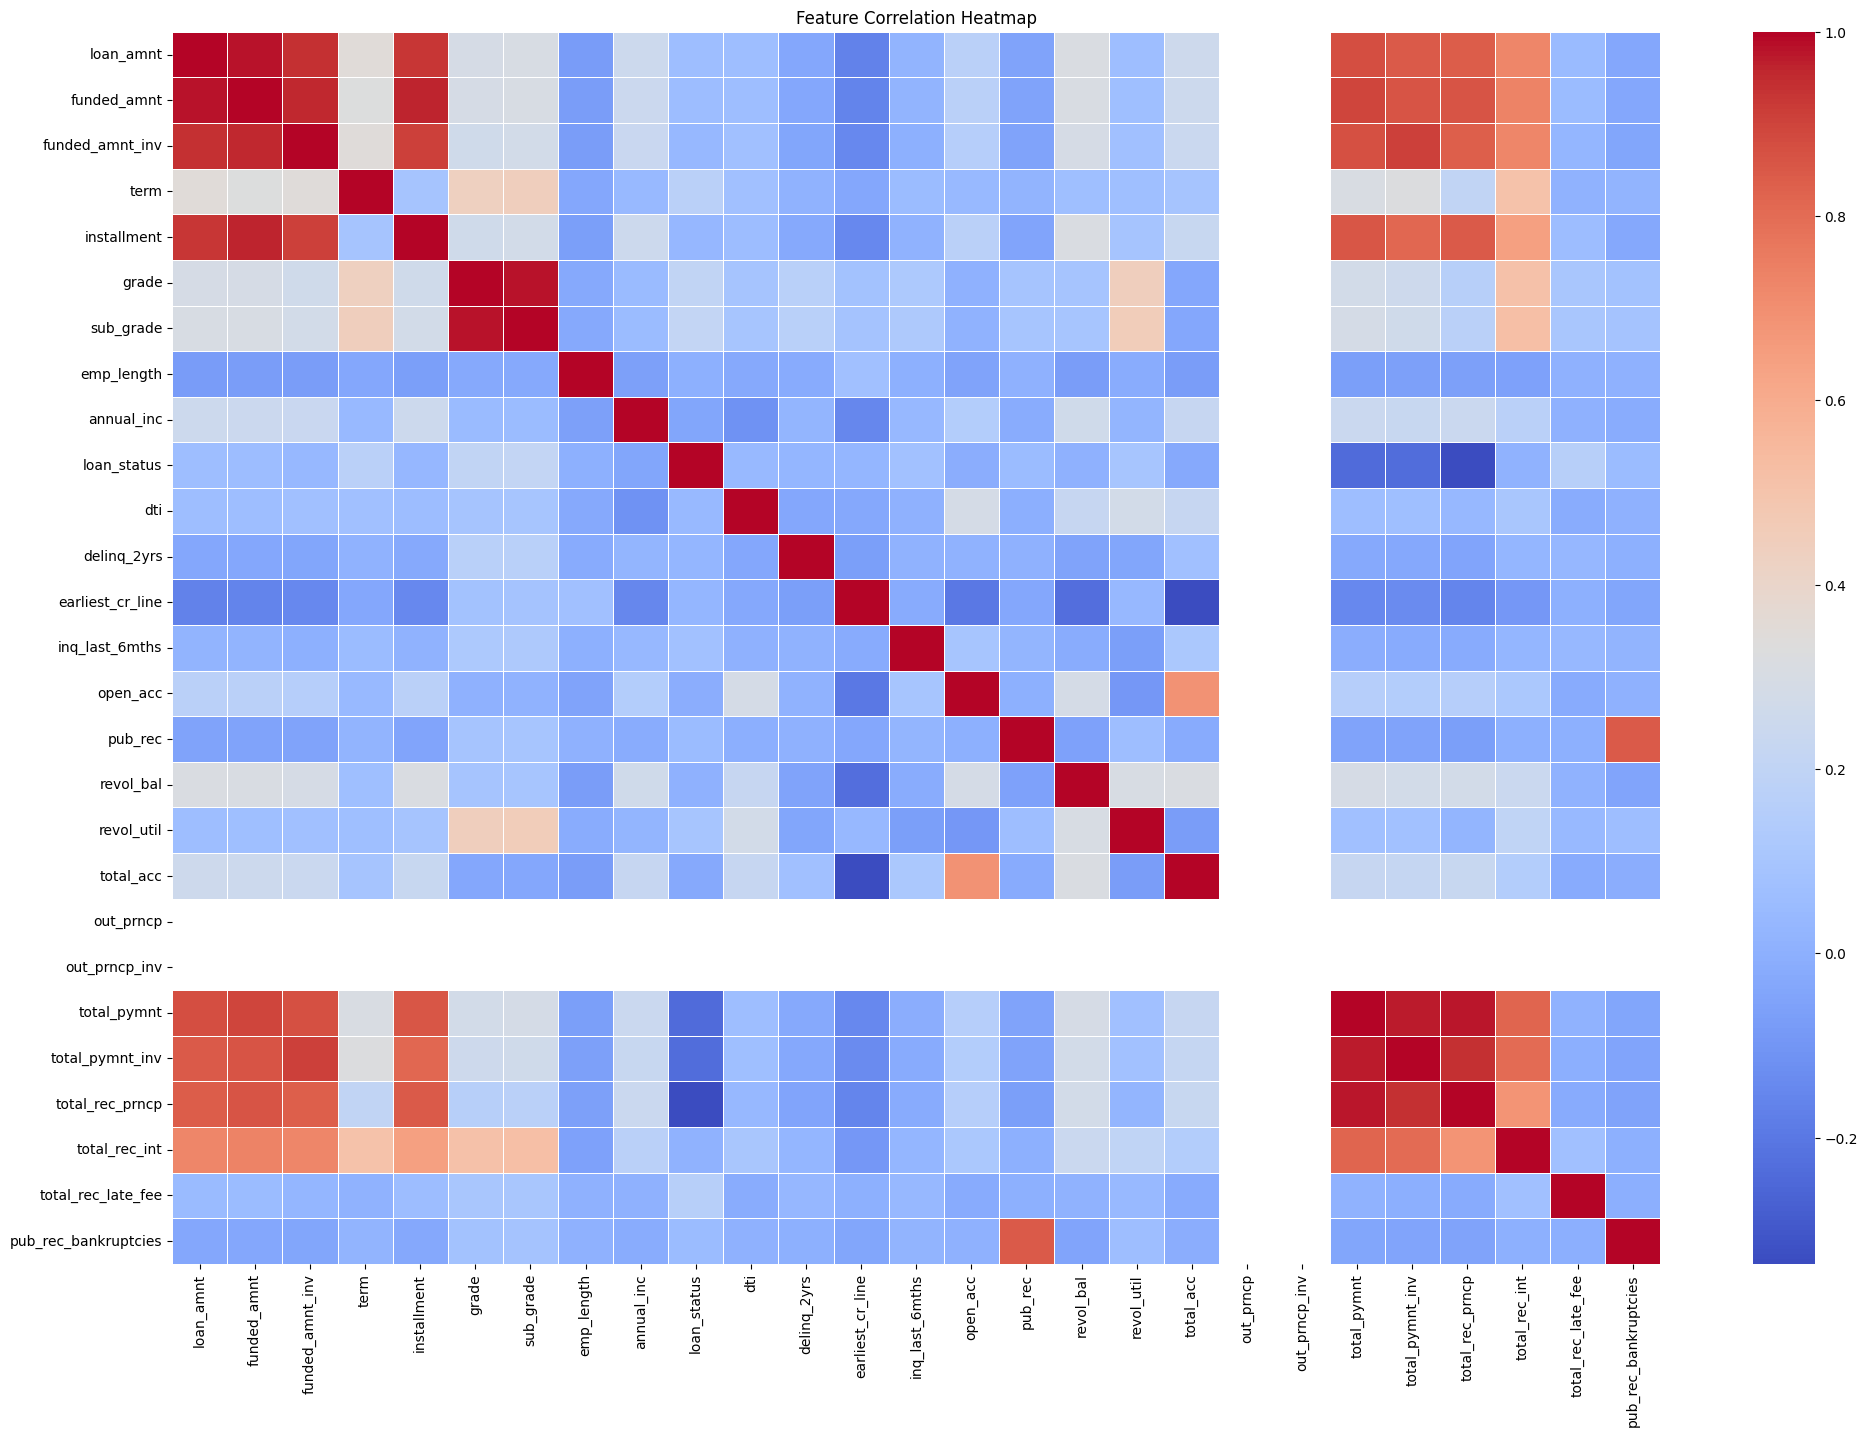

In [ ]:
# Show correlation matrix

annot=False
figsize=(24, 16)
cmap="coolwarm"
linewidths=0.5
columns_subset=None

if columns_subset is not None:
    data = df_encoded[columns_subset]
else:
    data = df_encoded.select_dtypes(include=[np.number])

# Compute the correlation matrix.
corr_matrix = data.corr()

# Create the heatmap.
plt.figure(figsize=figsize)
sns.heatmap(corr_matrix, annot=annot, fmt=".2f", cmap=cmap, linewidths=linewidths)
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
# [!Warning] Too slow
# Drop drop_highly_correlated_features
# df_train_clean_drop_hicorr, dropped = drop_highly_correlated_features(df_train_clean, threshold=0.75)
threshold = 0.75

# Create a mask for the upper triangle (excluding the diagonal)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identify columns to drop: any column with a correlation value greater than the threshold
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

# Drop these columns from the DataFrame
df_encoded_cleaned = df_encoded.drop(columns=to_drop)

In [ ]:
df_encoded_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27003 entries, 0 to 27002
Data columns (total 37 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   loan_amnt                            27003 non-null  int64  
 1   term                                 27003 non-null  int64  
 2   grade                                27003 non-null  int64  
 3   emp_length                           27003 non-null  int64  
 4   annual_inc                           27003 non-null  float64
 5   loan_status                          27003 non-null  int64  
 6   dti                                  27003 non-null  float64
 7   delinq_2yrs                          27003 non-null  int64  
 8   earliest_cr_line                     27003 non-null  int64  
 9   inq_last_6mths                       27003 non-null  int64  
 10  open_acc                             27003 non-null  int64  
 11  pub_rec                     

In [ ]:
df_encoded_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27003 entries, 0 to 27002
Data columns (total 37 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   loan_amnt                            27003 non-null  int64  
 1   term                                 27003 non-null  int64  
 2   grade                                27003 non-null  int64  
 3   emp_length                           27003 non-null  int64  
 4   annual_inc                           27003 non-null  float64
 5   loan_status                          27003 non-null  int64  
 6   dti                                  27003 non-null  float64
 7   delinq_2yrs                          27003 non-null  int64  
 8   earliest_cr_line                     27003 non-null  int64  
 9   inq_last_6mths                       27003 non-null  int64  
 10  open_acc                             27003 non-null  int64  
 11  pub_rec                     

# Apply LASSO

In [ ]:
# Separate features and target
X_lasso = df_encoded_cleaned.drop(columns=['loan_status'])
y_lasso = df_encoded_cleaned['loan_status'] # [todo] treat this as cat var
random_state=42

# Split the dataset into training and testing sets
X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(X_lasso, y_lasso,
                                                            test_size=0.2,
                                                            random_state=random_state)
# [ToDo] Handle missing values after split. apply on train dataset

# Standardize Features
scaler = StandardScaler()
X_train_lasso_scaled = scaler.fit_transform(X_train_lasso)
X_test_lasso_scaled = scaler.transform(X_test_lasso)


#
# Apply Lasso with cross-validation to find the optimal regularization parameter
alphas = np.logspace(-5, 0, 200)  # Experiment with a wider range of alphas
lasso_cv = LassoCV(alphas=alphas, cv=10, random_state=random_state)
lasso_cv.fit(X_train_lasso, y_train_lasso)

# Identify features with non-zero coefficients
selected_features = X_lasso.columns[lasso_cv.coef_ != 0]
print("Selected features:", list(selected_features))

# Evaluate performance on the test set
y_pred_lasso = lasso_cv.predict(X_test_lasso)
mse = mean_squared_error(y_test_lasso, y_pred_lasso)
print("Mean Squared Error:", mse)
# [todo] use accuray, precision, recall matrix to measure perfomance. this step is for lr model only

# [todo] althernative approach - recursive elimination/step wise/[skip]

Selected features: ['loan_amnt', 'term', 'grade', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'total_rec_late_fee', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT', 'verification_status_Source Verified', 'verification_status_Verified', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase', 'purpose_medical', 'purpose_moving', 'purpose_other', 'purpose_renewable_energy', 'purpose_small_business', 'purpose_vacation']
Mean Squared Error: 0.11614469479033178


# Standardize numerical features

# Before Feature engineering

In [ ]:
# [Todo] apply SHAP var analysis as initial screening stages
# Feature selection
X = df_encoded_cleaned[selected_features]  # Features
# X = df_encoded_cleaned.drop(columns=['loan_status'])  # All Features -> overfit
y = (df_encoded_cleaned['loan_status'] > 0.5).astype(int)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27003 entries, 0 to 27002
Data columns (total 32 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   loan_amnt                            27003 non-null  int64  
 1   term                                 27003 non-null  int64  
 2   grade                                27003 non-null  int64  
 3   emp_length                           27003 non-null  int64  
 4   annual_inc                           27003 non-null  float64
 5   dti                                  27003 non-null  float64
 6   delinq_2yrs                          27003 non-null  int64  
 7   earliest_cr_line                     27003 non-null  int64  
 8   inq_last_6mths                       27003 non-null  int64  
 9   open_acc                             27003 non-null  int64  
 10  pub_rec                              27003 non-null  int64  
 11  revol_bal                   

In [ ]:
def visualiseImbalanceData(y):
  # Visualize class imbalance in the target variable
  plt.figure(figsize=(8, 6))
  sns.countplot(x=y)
  plt.title("Class Distribution Before SMOTE")
  plt.xlabel("Class")
  plt.ylabel("Frequency")
  plt.show()

  # Additionally, print out the counts
  print("Class distribution:")
  print(y.value_counts())

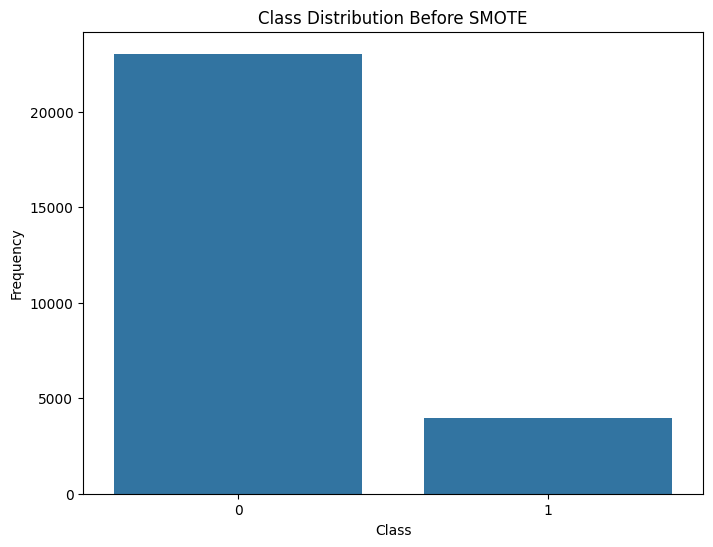

Class distribution:
loan_status
0    23026
1     3977
Name: count, dtype: int64


In [ ]:
visualiseImbalanceData(y)

In [ ]:
# Handle class imbalance using SMOTE [analyse whether data is imblance first]
# [ToDo] only apply to train dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

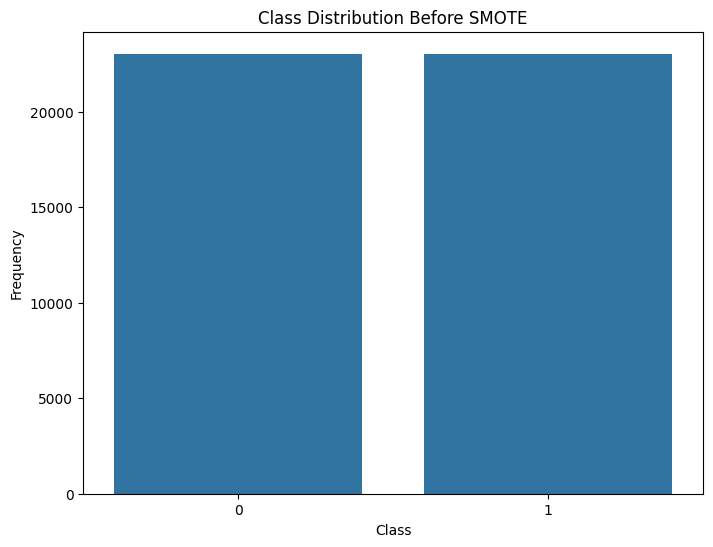

Class distribution:
loan_status
0    23026
1    23026
Name: count, dtype: int64


In [ ]:
visualiseImbalanceData(y_resampled)

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#[Todo] X_train further split into train and val -> train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42 [specify y var data ratio])
# [todo] SMOTE only X-train, not on val dataset and test dataset

In [ ]:
# Create a scaled version for models that require it (i.e. Logistic Regression)
scaler = StandardScaler()
numeric_columns = X_train.select_dtypes(include=['int64', 'float64']).columns
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])

numeric_columns = X_test.select_dtypes(include=['int64', 'float64']).columns
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns]) # only apply transform. not fit

In [ ]:
# Function to plot ROC curve
def plot_roc_curve(y_test, y_pred_proba, model_name):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    # Define the thresholds to highlight
    desired_thresholds = [0.3, 0.5, 0.7]

    # Function to find the closest threshold
    def find_closest_threshold(thresholds, desired_thresh):
        idx = np.argmin(np.abs(thresholds - desired_thresh))
        return idx

    # Highlight specific threshold points
    for thresh in desired_thresholds:
        idx = find_closest_threshold(thresholds, thresh)
        plt.scatter(fpr[idx], tpr[idx], label=f'Threshold ≈ {thresholds[idx]:.2f}', marker='o')

    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.show()


LogisticRegression Performance:
              precision    recall  f1-score   support

           0       0.78      0.88      0.83      4617
           1       0.87      0.75      0.80      4594

    accuracy                           0.82      9211
   macro avg       0.82      0.82      0.82      9211
weighted avg       0.82      0.82      0.82      9211



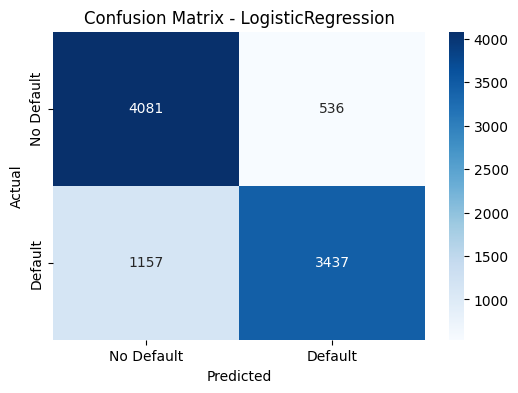

In [ ]:
# Define models
model = LogisticRegression(max_iter=1000, class_weight='balanced')

# Train the model
model.fit(X_train, y_train)

# Predictions on test data
y_pred = model.predict(X_test)

# Use predict_proba if available, otherwise decision_function
if hasattr(model, "predict_proba"):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    train_pred_proba = model.predict_proba(X_train)[:, 1]
else:
    y_pred_proba = model.decision_function(X_test)
    train_pred_proba = model.decision_function(X_train)

result = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_pred_proba),
        "Train Accuracy": accuracy_score(y_train, model.predict(X_train)),
        "Test Accuracy": accuracy_score(y_test, y_pred),
        "Train AUC": roc_auc_score(y_train, train_pred_proba),
        "Test AUC": roc_auc_score(y_test, y_pred_proba)
    }

# Print classification report for each model
print(f"\n{'LogisticRegression'} Performance:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix for each model
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix - {'LogisticRegression'}")
plt.show()

In [ ]:
# Convert the dictionary into a DataFrame
result_df = pd.DataFrame(result, index=[0]).T  # Transpose to have metrics as rows
result_df.columns = ['Score']
result_df = result_df.round(4)  # Optional: round the values for clarity

print("Model Performance Metrics:")
print(result_df)

Model Performance Metrics:
                 Score
Accuracy        0.8162
Precision       0.8651
Recall          0.7481
F1-score        0.8024
AUC             0.8869
Train Accuracy  0.8105
Test Accuracy   0.8162
Train AUC       0.8833
Test AUC        0.8869


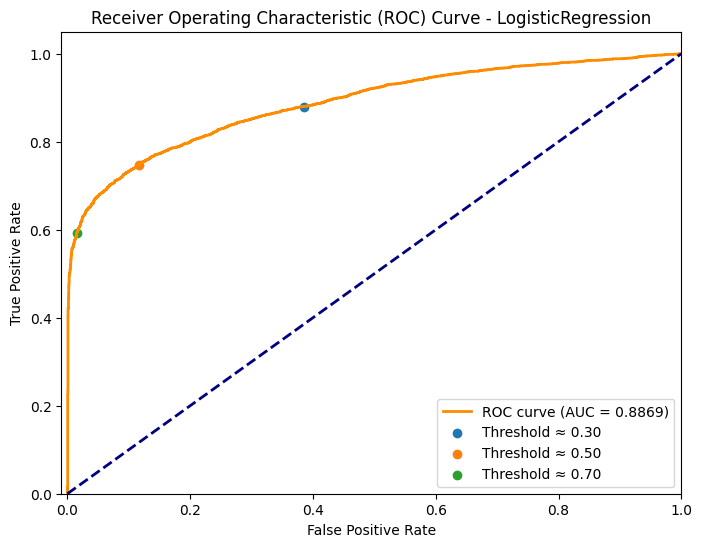

In [ ]:
plot_roc_curve(y_test, y_pred_proba, "LogisticRegression")


# pycaret analysis




In [ ]:
# ## Import the following packages
import datetime
import swifter
import mlflow
import pandas as pd
import numpy as np
import plotly.express as px
from tqdm.notebook import tqdm
from pathlib import Path
from pydantic import BaseModel
from ydata_profiling import ProfileReport
from pycaret.regression import RegressionExperiment
from pycaret.classification import ClassificationExperiment

In [ ]:
from pycaret.classification import setup, compare_models, pull, evaluate_model

# Set up the PyCaret classification environment.
# Replace 'target' with your actual target variable name.
exp_clf = setup(data=df_encoded_cleaned, target='loan_status', session_id=42, normalize=True)

# Compare all models available in PyCaret.
best_model = compare_models()

# Retrieve and display the results table.
results_df = pull()
print("Comparison of Model Results:")
print(results_df)

# Optionally, evaluate the best model further.
evaluate_model(best_model)

,Description,Value
0,Session id,42
1,Target,loan_status
2,Target type,Binary
3,Original data shape,"(27003, 37)"
4,Transformed data shape,"(27003, 37)"
5,Transformed train set shape,"(18902, 37)"
6,Transformed test set shape,"(8101, 37)"
7,Numeric features,17
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8631,0.7447,0.1092,0.7433,0.1898,0.1580,0.2490,2.6270
ada,Ada Boost Classifier,0.8626,0.7364,0.1128,0.7119,0.1941,0.1604,0.2454,0.7010
lightgbm,Light Gradient Boosting Machine,0.8626,0.7355,0.1236,0.6846,0.2088,0.1718,0.2500,1.9250
catboost,CatBoost Classifier,0.8622,0.7375,0.1236,0.6810,0.2088,0.1712,0.2489,7.7860
rf,Random Forest Classifier,0.8617,0.7165,0.0869,0.7693,0.1560,0.1301,0.2279,2.3460
xgboost,Extreme Gradient Boosting,0.8551,0.7061,0.1620,0.5257,0.2474,0.1915,0.2327,0.3120
lr,Logistic Regression,0.8538,0.7221,0.0532,0.5455,0.0966,0.0721,0.1346,0.5530
lda,Linear Discriminant Analysis,0.8535,0.7189,0.0812,0.5195,0.1400,0.1044,0.1606,0.0870
ridge,Ridge Classifier,0.8530,0.7189,0.0266,0.5605,0.0503,0.0366,0.0931,0.0690
dummy,Dummy Classifier,0.8527,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0570


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

Comparison of Model Results:
                                    Model  Accuracy     AUC  Recall   Prec.  \
gbc          Gradient Boosting Classifier    0.8631  0.7447  0.1092  0.7433   
ada                  Ada Boost Classifier    0.8626  0.7364  0.1128  0.7119   
lightgbm  Light Gradient Boosting Machine    0.8626  0.7355  0.1236  0.6846   
catboost              CatBoost Classifier    0.8622  0.7375  0.1236  0.6810   
rf               Random Forest Classifier    0.8617  0.7165  0.0869  0.7693   
xgboost         Extreme Gradient Boosting    0.8551  0.7061  0.1620  0.5257   
lr                    Logistic Regression    0.8538  0.7221  0.0532  0.5455   
lda          Linear Discriminant Analysis    0.8535  0.7189  0.0812  0.5195   
ridge                    Ridge Classifier    0.8530  0.7189  0.0266  0.5605   
dummy                    Dummy Classifier    0.8527  0.5000  0.0000  0.0000   
svm                   SVM - Linear Kernel    0.8524  0.6235  0.0338  0.4207   
et                 Extr

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [ ]:
from pycaret.regression import setup, compare_models, pull, evaluate_model

# Set up the PyCaret regression environment.
# Replace 'target' with your actual numeric target variable name.
exp_reg = setup(data=df_encoded_cleaned, target='loan_status', session_id=42, normalize=True)

# Compare all regression models available in PyCaret.
best_model = compare_models()

# Retrieve and display the results table.
results_df = pull()
print("Comparison of Regression Model Results:")
print(results_df)

# Optionally, evaluate the best model further.
evaluate_model(best_model)


,Description,Value
0,Session id,42
1,Target,loan_status
2,Target type,Regression
3,Original data shape,"(27003, 37)"
4,Transformed data shape,"(27003, 37)"
5,Transformed train set shape,"(18902, 37)"
6,Transformed test set shape,"(8101, 37)"
7,Numeric features,17
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.2170,0.1073,0.3275,0.1391,0.2295,0.7410,2.4710
lightgbm,Light Gradient Boosting Machine,0.2142,0.1085,0.3293,0.1294,0.2315,0.7304,1.2080
catboost,CatBoost Regressor,0.2156,0.1094,0.3306,0.1223,0.2327,0.7296,4.9310
ada,AdaBoost Regressor,0.2201,0.1114,0.3336,0.1068,0.2335,0.7612,0.2080
rf,Random Forest Regressor,0.2241,0.1118,0.3342,0.1032,0.2380,0.7109,9.1660
br,Bayesian Ridge,0.2302,0.1149,0.3389,0.0783,0.2372,0.7844,0.0680
lr,Linear Regression,0.2300,0.1149,0.3389,0.0782,0.2373,0.7829,0.0570
ridge,Ridge Regression,0.2300,0.1149,0.3389,0.0782,0.2373,0.7829,0.0510
lar,Least Angle Regression,0.2303,0.1150,0.3390,0.0777,0.2374,0.7823,0.0540
omp,Orthogonal Matching Pursuit,0.2326,0.1164,0.3410,0.0672,0.2386,0.7948,0.0930


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

Comparison of Regression Model Results:
                                    Model     MAE     MSE    RMSE      R2  \
gbr           Gradient Boosting Regressor  0.2170  0.1073  0.3275  0.1391   
lightgbm  Light Gradient Boosting Machine  0.2142  0.1085  0.3293  0.1294   
catboost               CatBoost Regressor  0.2156  0.1094  0.3306  0.1223   
ada                    AdaBoost Regressor  0.2201  0.1114  0.3336  0.1068   
rf                Random Forest Regressor  0.2241  0.1118  0.3342  0.1032   
br                         Bayesian Ridge  0.2302  0.1149  0.3389  0.0783   
lr                      Linear Regression  0.2300  0.1149  0.3389  0.0782   
ridge                    Ridge Regression  0.2300  0.1149  0.3389  0.0782   
lar                Least Angle Regression  0.2303  0.1150  0.3390  0.0777   
omp           Orthogonal Matching Pursuit  0.2326  0.1164  0.3410  0.0672   
xgboost         Extreme Gradient Boosting  0.2225  0.1177  0.3429  0.0557   
et                  Extra Trees Regr

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

# SHAP before feature engineering

In [ ]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import shap
import pandas as pd
import numpy as np
shap.initjs()

X = df_encoded_cleaned.drop("loan_status", axis=1) # Independent variables
y = df_encoded_cleaned.loan_status # Dependent variable

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Train a machine learning model Gradient Boosting (best model)
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
# [TODO] can we increase weight? > we can incerase weight of target var 0-1, GrandientBoost or XGBoost. these model can handle missing values

# Make prediction on the testing data
y_pred = clf.predict(X_test)

# Classification Report
print(classification_report(y_pred, y_test))

explainer = shap.Explainer(clf)
shap_values = explainer.shap_values(X_test)

              precision    recall  f1-score   support

           0       0.99      0.87      0.93      7923
           1       0.11      0.70      0.19       178

    accuracy                           0.87      8101
   macro avg       0.55      0.79      0.56      8101
weighted avg       0.97      0.87      0.91      8101



AssertionError: Summary plots need a matrix of shap_values, not a vector.

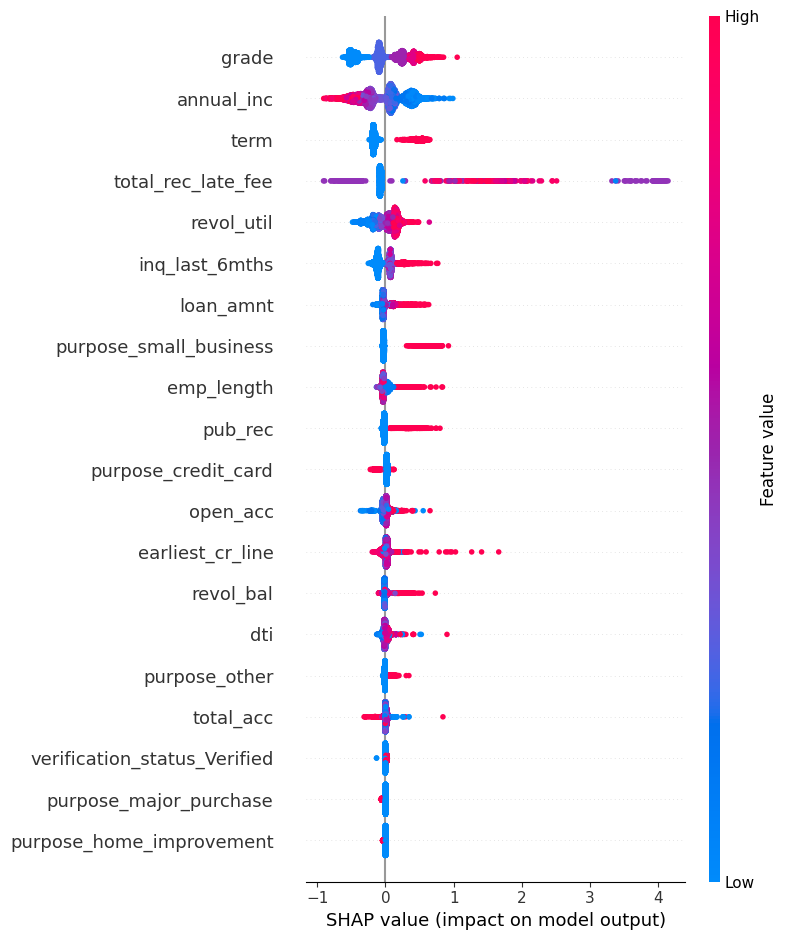

In [ ]:
# SHAP summary plot
# purpose is to understand rel between feature and target
shap.summary_plot(shap_values, X_test)

# Feature engineering for dynamic model

In [ ]:
# clean data before
df_fe = df_train_raw.copy()

In [ ]:
# 1. Drop unnecessary columns (ignore if any are missing).
# 'mths_since_last_record', 'mths_since_last_delinq' dropped due to high missing values > 60%
# 'addr_state' dropped due to high number of cols after one-hot encoding
# 'issue_d', 'last_pymnt_d' and 'last_pymnt_amnt' might introduce data leakage because these info will be available only after default
# 'last_credit_pull_d' -> If this column reflects a credit inquiry date made after a significant loan event (e.g., a default or a restructuring), it might leak future information.
# 'recoveries' and 'collection_recovery_fee' -> suspect data leakage after analysing using SHAP where this features standout
# 'int_rate' -> Interest Rate on the loan. suspect data leakage after analysing using SHAP where this features standout
cols_to_drop = [
    'id',
    'member_id',
    'url',
    'desc',
    'title',
    'emp_title',
    'zip_code',
    'addr_state',
    'mths_since_last_record',
    'mths_since_last_delinq',
    'last_pymnt_d',
    'last_pymnt_amnt',
    'last_credit_pull_d',
    'issue_d',
    'recoveries',
    'collection_recovery_fee',
    'int_rate'
]
df_fe.drop(columns=cols_to_drop, errors='ignore', inplace=True)

# 2. Convert interest rate from percentage string to float.
if 'int_rate' in df_fe.columns:
    df_fe['int_rate'] = df_fe['int_rate'].str.rstrip('%').astype(float)
#2.1 Convert revol_util from percentage string to float.
if 'revol_util' in df_fe.columns:
    df_fe['revol_util'] = df_fe['revol_util'].str.rstrip('%').astype(float)

# 3. Convert date columns to datetime objects.
date_columns = {
      #'issue_d': '%b-%y',
     # 'last_pymnt_d': '%b-%y',
      'last_credit_pull_d': '%b-%y',
      'earliest_cr_line': '%b-%y'
}
for col, date_format in date_columns.items():
    if col in df_fe.columns:
        df_fe[col] = pd.to_datetime(df_fe[col], format=date_format)

## 1. Time-based feature

### ✅ Loan Age (Months)
**Definition**: The number of months since the borrower’s earliest recorded credit line.

#### Why it matters?
* A longer credit history typically indicates a more experienced borrower, reducing default risk.
* New borrowers tend to have higher risk.
* Formula:Loan Age (Months)=(2025−Earliest Credit Line Year)×12+(1−Month)*Loan Age (Months)=(2025−Earliest Credit Line Year)×12+(1−Month)

* **Application in Model**:
Used to differentiate between new vs. old borrowers.
Helps in time-series-based default predictions.



In [ ]:
# --- 1. Time-Based Features ---

# Convert earliest credit line to datetime and extract year
df_fe['earliest_cr_line'] = pd.to_datetime(df_fe['earliest_cr_line'], format='%b-%y', errors='coerce')

# Compute Loan Age (Months) based on the assumption that the current year is 2025
df_fe['loan_age_months'] = (2025 - df_fe['earliest_cr_line'].dt.year) * 12

# Compute rolling default rate by year
df_fe['yearly_default_rate'] = df_fe.groupby(df_fe['earliest_cr_line'].dt.year)['loan_status'].transform('mean')

In [ ]:
df_fe['yearly_default_rate']

,yearly_default_rate
0,0.131398
1,0.162933
2,0.157157
3,0.155502
4,0.157157
...,...
26998,0.131398
26999,0.157157
27000,0.131631
27001,0.137255


In [ ]:
# --- 2. Credit Behavior Features ---

# Credit Utilization Ratio
df_fe['credit_utilization_ratio'] = df_fe['revol_bal'] / (df_fe['loan_amnt'] + 1)  # Avoid division by zero

# Rolling Average of Debt-to-Income Ratio (DTI)
df_fe['rolling_dti'] = df_fe['dti'].rolling(window=3, min_periods=1).mean()

In [ ]:
# --- 3. Aggregated Default History Features ---
#====== ! Wrong =====
# [todo] if we can identify if it is same client. sort by time sequence, check if there is any default
#====== ! Wrong =====
# Compute past default rate for loan purpose using encoded purpose features
purpose_columns = [col for col in df_fe.columns if col.startswith('purpose_')]
df_fe['purpose_default_rate'] = df_fe[purpose_columns].mul(df_fe['loan_status'], axis=0).sum(axis=1) / df_fe[purpose_columns].sum(axis=1).replace(0, 1)

In [ ]:
# --- 4. Risk Indicator Transformations ---

# Log transformation for skewed variables. same as standardsclar
skewed_cols = ['loan_amnt', 'annual_inc', 'dti']
for col in skewed_cols:
    df_fe[col] = np.log1p(df_fe[col])  # log1p to handle zero values

In [ ]:
# Standardization for Interest Rate
# df_fe['int_rate'] = (df_fe['int_rate'] - df_fe['int_rate'].mean()) / df_fe['int_rate'].std()

# Drop original date column (earliest_cr_line) after feature extraction
df_fe.drop(columns=['earliest_cr_line'], inplace=True)


In [ ]:

# Display updated dataset with new features
from IPython.display import display
display(df_fe)

,loan_amnt,funded_amnt,funded_amnt_inv,term,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,...,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,pub_rec_bankruptcies,loan_age_months,yearly_default_rate,credit_utilization_ratio,rolling_dti,purpose_default_rate
0,9.210440,10000,9975.0,36 months,338.05,C,C1,4 years,RENT,10.518700,...,11943.68,10000.00,1973.61,0.0,0.0,276,0.131398,1.021598,16.860000,0.0
1,9.546884,14000,13775.0,36 months,437.94,A,A5,< 1 year,RENT,11.561725,...,15470.79,14000.00,1723.48,0.0,0.0,240,0.162933,0.950432,11.595000,0.0
2,9.156518,9475,9475.0,36 months,301.04,A,A5,9 years,OWN,10.203629,...,10472.09,9475.00,997.09,0.0,0.0,312,0.157157,0.830097,10.086667,0.0
3,8.294300,4000,4000.0,36 months,124.04,A,A4,10+ years,OWN,10.463132,...,4425.26,4000.00,425.26,0.0,0.0,336,0.155502,7.337666,14.066667,0.0
4,8.188967,3600,3600.0,36 months,110.54,A,A2,1 year,RENT,11.002117,...,2321.34,2004.17,306.88,0.0,0.0,312,0.157157,4.304915,19.136667,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26998,9.392745,12000,12000.0,36 months,375.49,A,A4,< 1 year,RENT,11.225257,...,13514.90,12000.00,1514.90,0.0,0.0,276,0.131398,0.236147,14.970000,0.0
26999,8.131825,3400,3400.0,60 months,85.40,D,D5,NaN,RENT,10.778977,...,4440.80,2750.79,1672.96,0.0,1.0,312,0.157157,1.368127,11.876667,0.0
27000,8.922792,7500,3413.8,36 months,241.41,B,B3,8 years,RENT,11.066654,...,3945.28,7500.00,1188.62,0.0,NaN,384,0.131631,0.080389,5.946667,0.0
27001,9.210440,10000,10000.0,36 months,307.04,A,A2,2 years,MORTGAGE,11.082158,...,11053.31,10000.00,1053.31,0.0,0.0,564,0.137255,4.666233,5.380000,0.0


In [ ]:
# Calculate percentage of missing values for each column
missing_percent = df_fe.isnull().mean() * 100

# Create a DataFrame to display the results neatly
missing_table = pd.DataFrame({
    'Column': missing_percent.index,
    'Missing Percentage': missing_percent.values
})

# Sort the table by missing percentage (highest first) and display it
missing_table.sort_values(by='Missing Percentage', ascending=False, inplace=True)
print(missing_table)

                      Column  Missing Percentage
7                 emp_length            2.703403
28      pub_rec_bankruptcies            1.862756
19                revol_util            0.129615
25           total_rec_prncp            0.000000
20                 total_acc            0.000000
21                 out_prncp            0.000000
22             out_prncp_inv            0.000000
23               total_pymnt            0.000000
24           total_pymnt_inv            0.000000
0                  loan_amnt            0.000000
26             total_rec_int            0.000000
18                 revol_bal            0.000000
29           loan_age_months            0.000000
30       yearly_default_rate            0.000000
31  credit_utilization_ratio            0.000000
32               rolling_dti            0.000000
27        total_rec_late_fee            0.000000
17                   pub_rec            0.000000
1                funded_amnt            0.000000
16                  

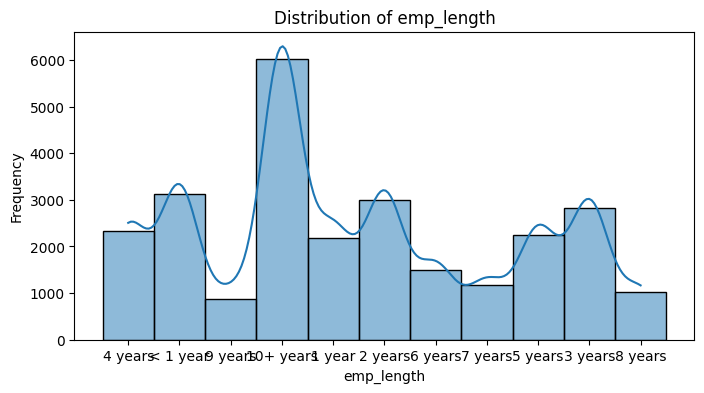

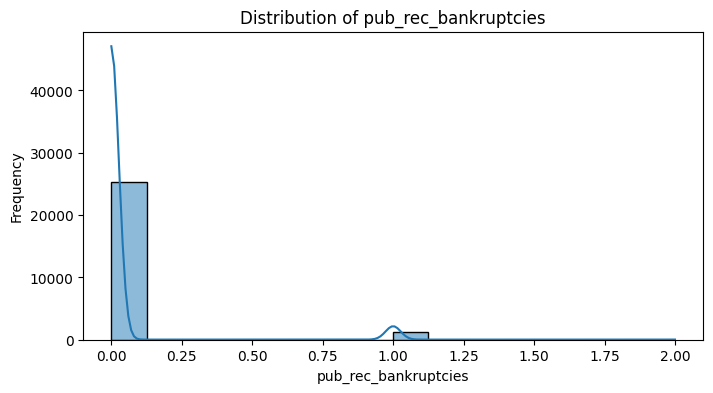

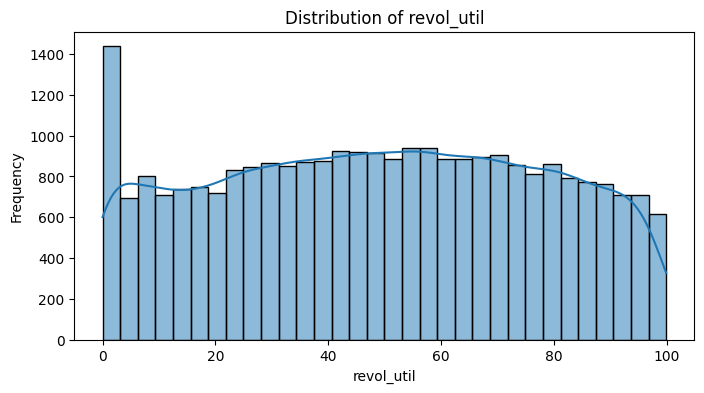

In [ ]:
# Visualise numeric columns
numeric_cols = ['emp_length', 'pub_rec_bankruptcies', 'revol_util']
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df_fe[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [ ]:
# Handle missing values. Drop if it is not normal distribution
df_fe['pub_rec_bankruptcies'].fillna(df_fe[col].mode(), inplace=True)
df_fe['emp_length'].fillna(df_fe[col].median(), inplace=True)
df_fe['revol_util'].fillna(df_fe[col].mean(), inplace=True)

In [ ]:
# 3. Convert date columns to datetime objects.
date_columns = {
      'last_credit_pull_d': '%b-%y',
      'earliest_cr_line': '%b-%y'
}
for col, date_format in date_columns.items():
    if col in df_fe.columns:
        df_fe[col] = pd.to_datetime(df_fe[col], format=date_format)

# 3.1 Convert date to ordinal numerical data
datetime_cols = df_fe.select_dtypes(include=['datetime64[ns]']).columns
for col in datetime_cols:
    df_fe[col] = df_fe[col].apply(lambda x: x.toordinal() if pd.notnull(x) else None)



In [ ]:
df_fe['emp_length']

,emp_length
0,4 years
1,< 1 year
2,9 years
3,10+ years
4,1 year
...,...
26998,< 1 year
26999,49.1
27000,8 years
27001,2 years


In [ ]:
# 4. Label encode specified ordinal columns.
# Define the mapping from text to numeric values
emp_length_map = {
    '< 1 year': 0,
    '1 year': 1,
    '2 years': 2,
    '3 years': 3,
    '4 years': 4,
    '5 years': 5,
    '6 years': 6,
    '7 years': 7,
    '8 years': 8,
    '9 years': 9,
    '10+ years': 10,
    'n/a': np.nan
}

# Convert emp_length to a numeric column using the map
df_fe['emp_length_numeric'] = df_fe['emp_length'].map(emp_length_map)

# 5. Identify any remaining categorical columns and apply one-hot encoding.
# require for logistic regression only
categorical_cols = df_fe.select_dtypes(include=['object']).columns
print("Categorical Columns for one-hot encoding:", list(categorical_cols))
df_fe = pd.get_dummies(df_fe, columns=categorical_cols, drop_first=True)

Categorical Columns for one-hot encoding: ['term', 'grade', 'sub_grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose']


In [ ]:
df_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27003 entries, 0 to 27002
Data columns (total 99 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   loan_amnt                            27003 non-null  float64
 1   funded_amnt                          27003 non-null  int64  
 2   funded_amnt_inv                      27003 non-null  float64
 3   installment                          27003 non-null  float64
 4   annual_inc                           27003 non-null  float64
 5   loan_status                          27003 non-null  int64  
 6   dti                                  27003 non-null  float64
 7   delinq_2yrs                          27003 non-null  int64  
 8   inq_last_6mths                       27003 non-null  int64  
 9   open_acc                             27003 non-null  int64  
 10  pub_rec                              27003 non-null  int64  
 11  revol_bal                   

In [ ]:
# Handle missing values.
df_fe.dropna(inplace=True)

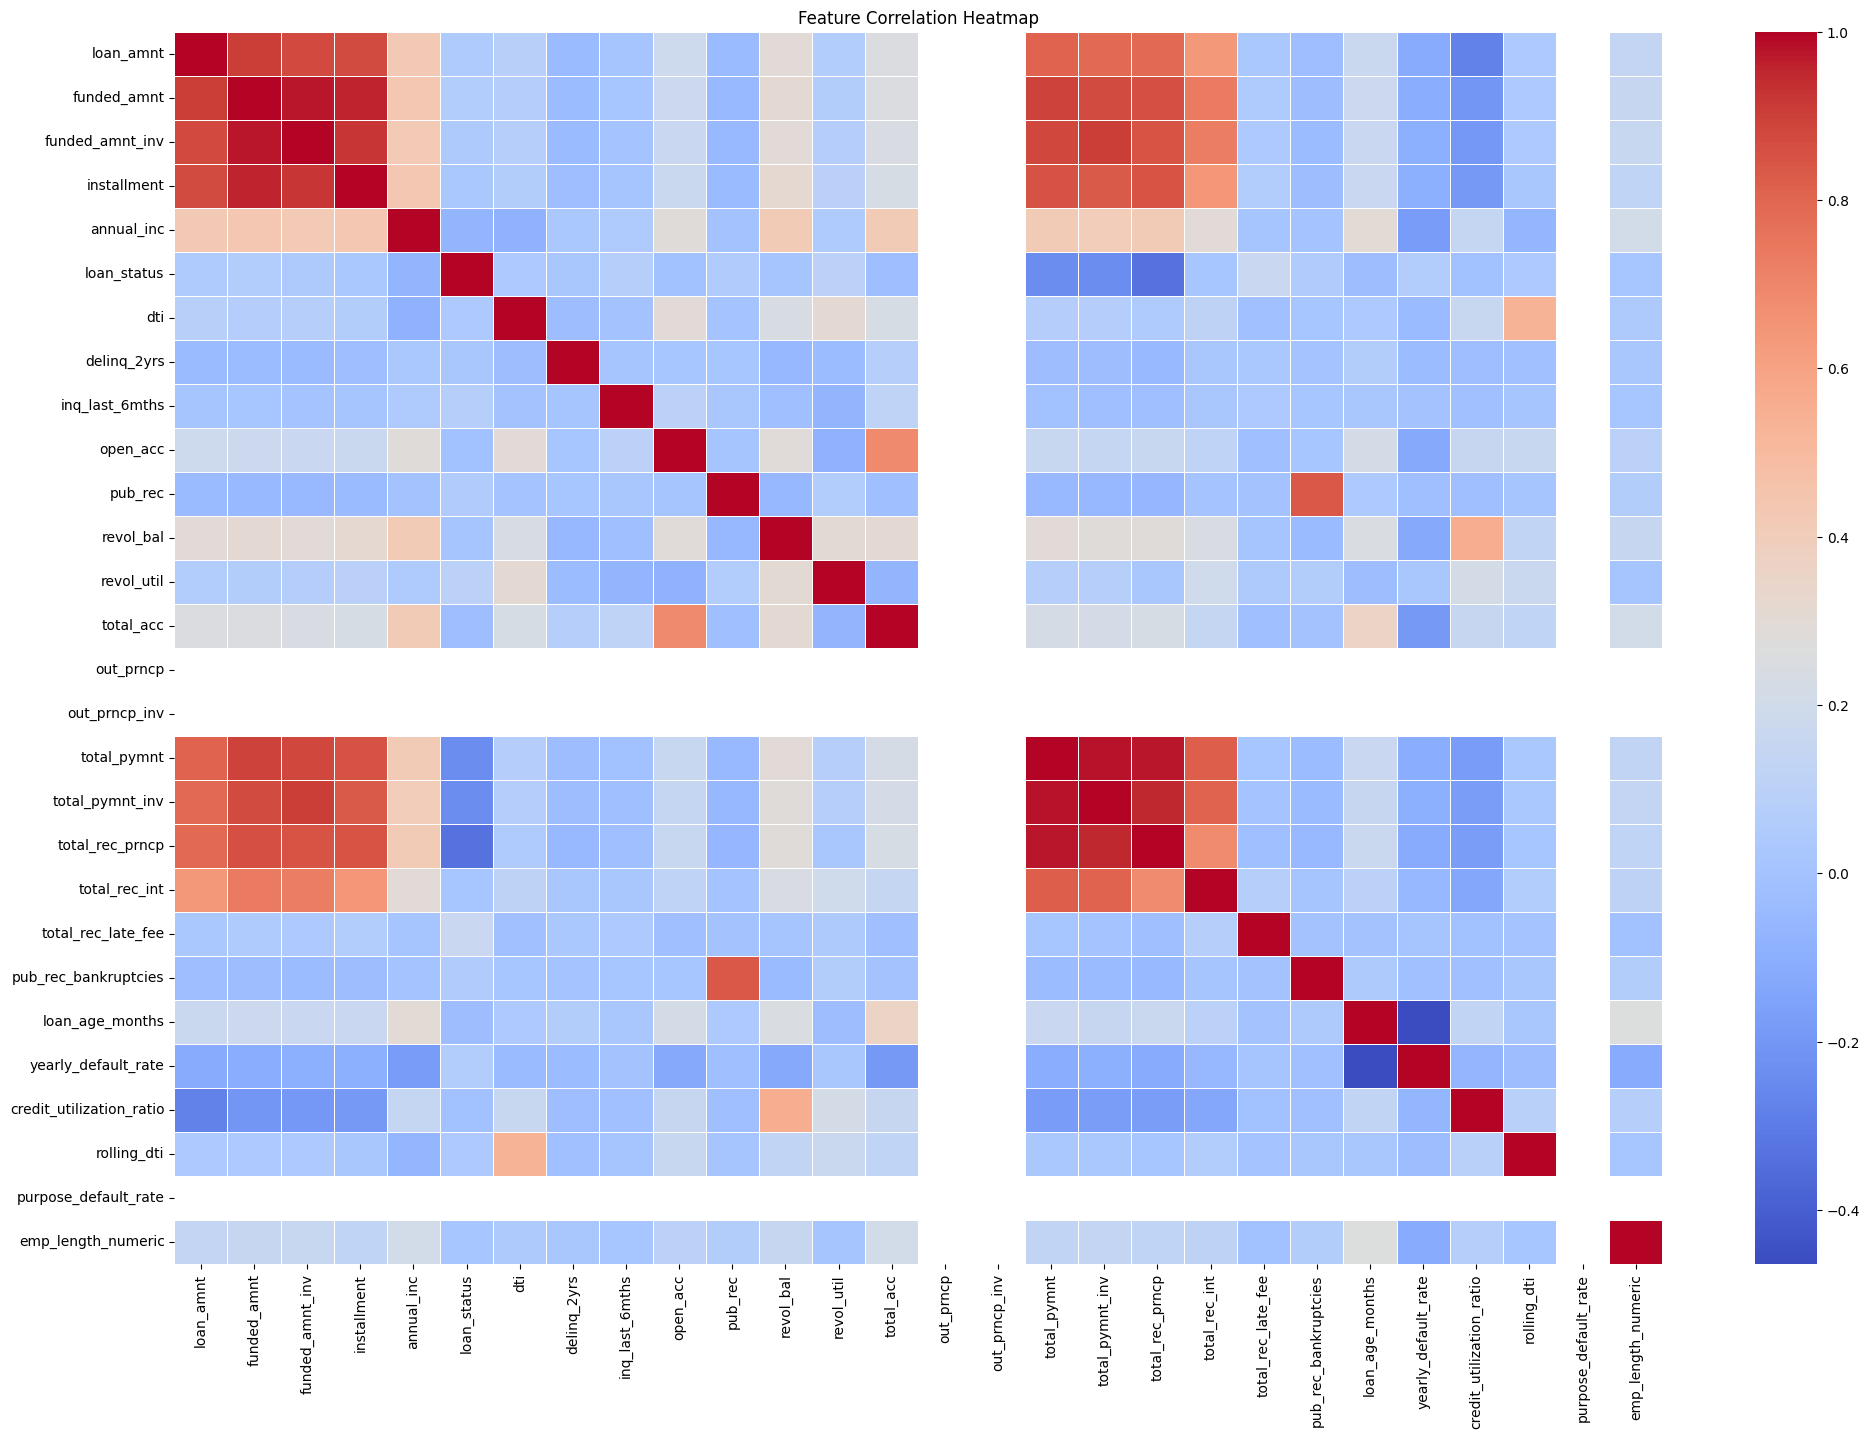

In [ ]:
# Show correlation matrix

annot=False
figsize=(24, 16)
cmap="coolwarm"
linewidths=0.5
columns_subset=None

if columns_subset is not None:
    data = df_fe[columns_subset]
else:
    data = df_fe.select_dtypes(include=[np.number])

# Compute the correlation matrix.
corr_matrix = data.corr()

# Create the heatmap.
plt.figure(figsize=figsize)
sns.heatmap(corr_matrix, annot=annot, fmt=".2f", cmap=cmap, linewidths=linewidths)
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
# [!Warning] Too slow
# Drop drop_highly_correlated_features
# df_train_clean_drop_hicorr, dropped = drop_highly_correlated_features(df_train_clean, threshold=0.75)
threshold = 0.75

# Create a mask for the upper triangle (excluding the diagonal)
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identify columns to drop: any column with a correlation value greater than the threshold
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

# Drop these columns from the DataFrame
df_fe_cleaned = df_fe.drop(columns=to_drop)

In [ ]:
# Fixed feature naming standard errors such as str containing [, ] < etc
import re

# Remove disallowed characters and replace spaces with underscores
df_fe_cleaned.columns = [
    re.sub(r'[\[\]<>]', '', col).strip().replace(" ", "_")
    for col in df_fe_cleaned.columns
]

In [ ]:
df_fe_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25770 entries, 0 to 27002
Data columns (total 91 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   loan_amnt                            25770 non-null  float64
 1   annual_inc                           25770 non-null  float64
 2   loan_status                          25770 non-null  int64  
 3   dti                                  25770 non-null  float64
 4   delinq_2yrs                          25770 non-null  int64  
 5   inq_last_6mths                       25770 non-null  int64  
 6   open_acc                             25770 non-null  int64  
 7   pub_rec                              25770 non-null  int64  
 8   revol_bal                            25770 non-null  int64  
 9   revol_util                           25770 non-null  float64
 10  total_acc                            25770 non-null  int64  
 11  out_prncp                        

In [ ]:
# Separate features and target
X_lasso = df_fe_cleaned.drop(columns=['loan_status'])
y_lasso = df_fe_cleaned['loan_status']
random_state=42

# Split the dataset into training and testing sets
X_train_lasso, X_test_lasso, y_train_lasso, y_test_lasso = train_test_split(X_lasso, y_lasso,
                                                            test_size=0.2,
                                                            random_state=random_state)

# Standardize Features
scaler = StandardScaler()
X_train_lasso_scaled = scaler.fit_transform(X_train_lasso)
X_test_lasso_scaled = scaler.transform(X_test_lasso)


# Apply Lasso with cross-validation to find the optimal regularization parameter
alphas = np.logspace(-5, 0, 200)  # Experiment with a wider range of alphas
lasso_cv = LassoCV(alphas=alphas, cv=10, random_state=random_state)
lasso_cv.fit(X_train_lasso_scaled, y_train_lasso)

# Identify features with non-zero coefficients
selected_features = X_lasso.columns[lasso_cv.coef_ != 0]
print("Selected features:", list(selected_features))

# Evaluate performance on the test set
y_pred_lasso = lasso_cv.predict(X_test_lasso_scaled)
mse = mean_squared_error(y_test_lasso, y_pred_lasso)
print("Mean Squared Error:", mse)

Selected features: ['loan_amnt', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_rec_late_fee', 'yearly_default_rate', 'credit_utilization_ratio', 'rolling_dti', 'emp_length_numeric', 'term__60_months', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G', 'sub_grade_A2', 'sub_grade_A3', 'sub_grade_A4', 'sub_grade_A5', 'sub_grade_B1', 'sub_grade_B4', 'sub_grade_B5', 'sub_grade_C2', 'sub_grade_C3', 'sub_grade_D1', 'sub_grade_D2', 'sub_grade_D3', 'sub_grade_D4', 'sub_grade_E2', 'sub_grade_E3', 'sub_grade_E4', 'sub_grade_E5', 'sub_grade_F2', 'sub_grade_F3', 'sub_grade_F4', 'sub_grade_F5', 'sub_grade_G1', 'sub_grade_G2', 'sub_grade_G3', 'emp_length_10+_years', 'emp_length_4_years', 'emp_length_6_years', 'emp_length_7_years', 'emp_length__1_year', 'verification_status_Verified', 'purpose_credit_card', 'purpose_educational', 'purpose_home_improvement', 'purpose_major_purchase', 'purpose_medical', 'purpose_other', 'purpose_renewa

In [ ]:
# Feature selection
X = df_fe_cleaned[selected_features]  # Features
y = (df_fe_cleaned['loan_status'] > 0.5).astype(int)
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25770 entries, 0 to 27002
Data columns (total 59 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   loan_amnt                     25770 non-null  float64
 1   annual_inc                    25770 non-null  float64
 2   dti                           25770 non-null  float64
 3   delinq_2yrs                   25770 non-null  int64  
 4   inq_last_6mths                25770 non-null  int64  
 5   open_acc                      25770 non-null  int64  
 6   pub_rec                       25770 non-null  int64  
 7   revol_bal                     25770 non-null  int64  
 8   revol_util                    25770 non-null  float64
 9   total_rec_late_fee            25770 non-null  float64
 10  yearly_default_rate           25770 non-null  float64
 11  credit_utilization_ratio      25770 non-null  float64
 12  rolling_dti                   25770 non-null  float64
 13  emp_le

In [ ]:
# Handle class imbalance using SMOTE [analyse whether data is imblance first]
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
# Create a scaled version for models that require it (i.e. Logistic Regression)
scaler = StandardScaler()
numeric_columns = X_train.select_dtypes(include=['int64', 'float64']).columns
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])

numeric_columns = X_test.select_dtypes(include=['int64', 'float64']).columns
X_test[numeric_columns] = scaler.fit_transform(X_test[numeric_columns])

In [ ]:
# Check for columns with [, ], or < in their names
invalid_chars = ['[', ']', '<']
invalid_cols = [col for col in X_train.columns if any(char in col for char in invalid_chars)]
print(f"Columns with invalid characters: {invalid_cols}")

# Replace invalid characters with underscores or other valid characters
for col in invalid_cols:
    new_col = col.replace('[', '_').replace(']', '_').replace('<', '_')
    X_train.rename(columns={col: new_col}, inplace=True)
    X_test.rename(columns={col: new_col}, inplace=True)  # Ensure X_test has the same changes

Columns with invalid characters: []


In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "CatBoost": CatBoostClassifier(verbose=0),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35262 entries, 17567 to 15795
Data columns (total 59 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   loan_amnt                     35262 non-null  float64
 1   annual_inc                    35262 non-null  float64
 2   dti                           35262 non-null  float64
 3   delinq_2yrs                   35262 non-null  float64
 4   inq_last_6mths                35262 non-null  float64
 5   open_acc                      35262 non-null  float64
 6   pub_rec                       35262 non-null  float64
 7   revol_bal                     35262 non-null  float64
 8   revol_util                    35262 non-null  float64
 9   total_rec_late_fee            35262 non-null  float64
 10  yearly_default_rate           35262 non-null  float64
 11  credit_utilization_ratio      35262 non-null  float64
 12  rolling_dti                   35262 non-null  float64
 13  em


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      4424
           1       0.88      0.80      0.84      4392

    accuracy                           0.85      8816
   macro avg       0.85      0.85      0.84      8816
weighted avg       0.85      0.85      0.84      8816



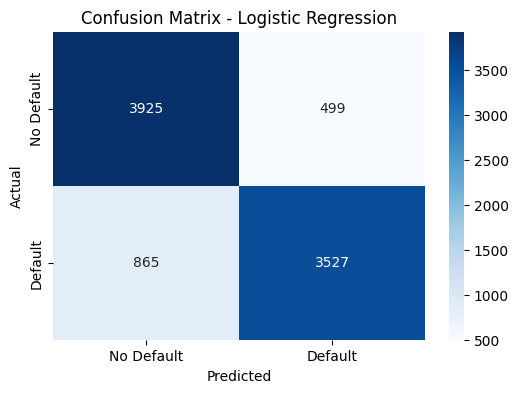

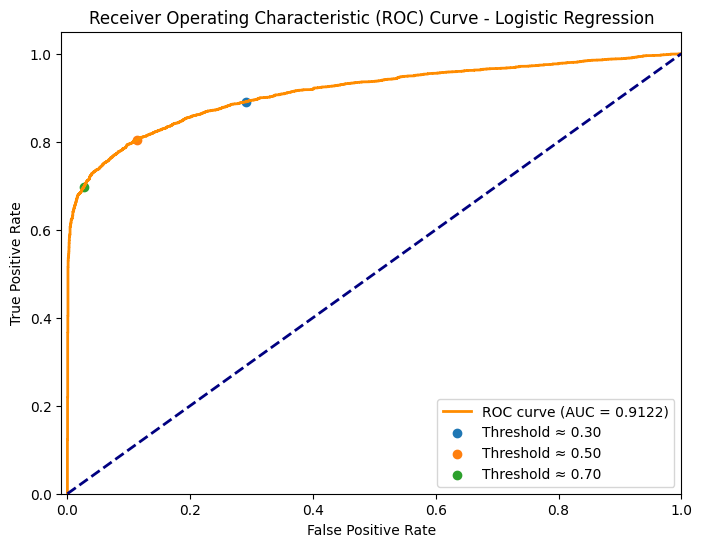


XGBoost Performance:
              precision    recall  f1-score   support

           0       0.90      0.43      0.58      4424
           1       0.62      0.95      0.75      4392

    accuracy                           0.69      8816
   macro avg       0.76      0.69      0.67      8816
weighted avg       0.76      0.69      0.67      8816



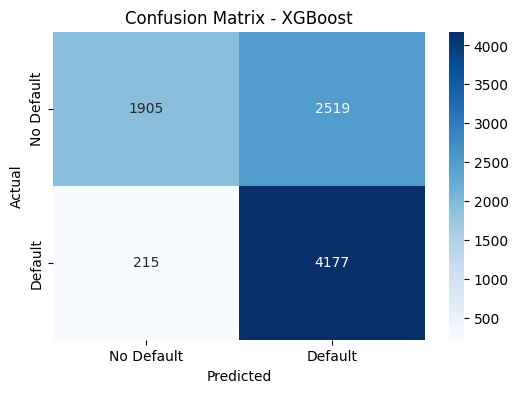

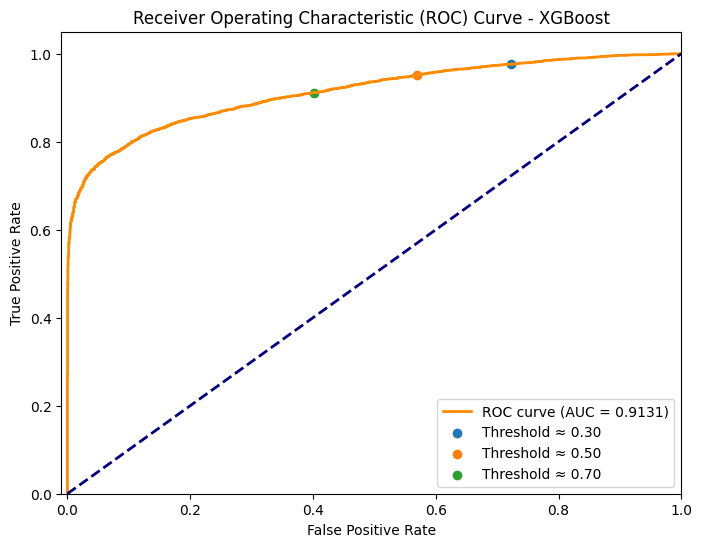


CatBoost Performance:
              precision    recall  f1-score   support

           0       0.93      0.19      0.31      4424
           1       0.55      0.99      0.70      4392

    accuracy                           0.58      8816
   macro avg       0.74      0.59      0.51      8816
weighted avg       0.74      0.58      0.51      8816



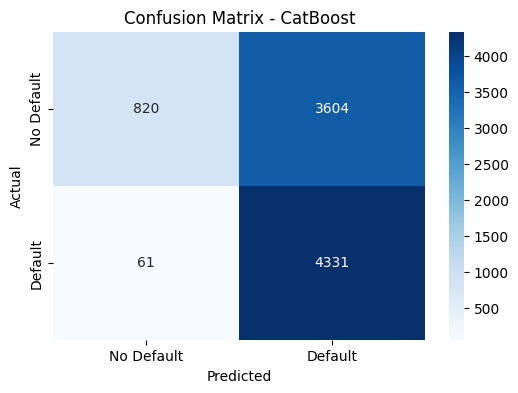

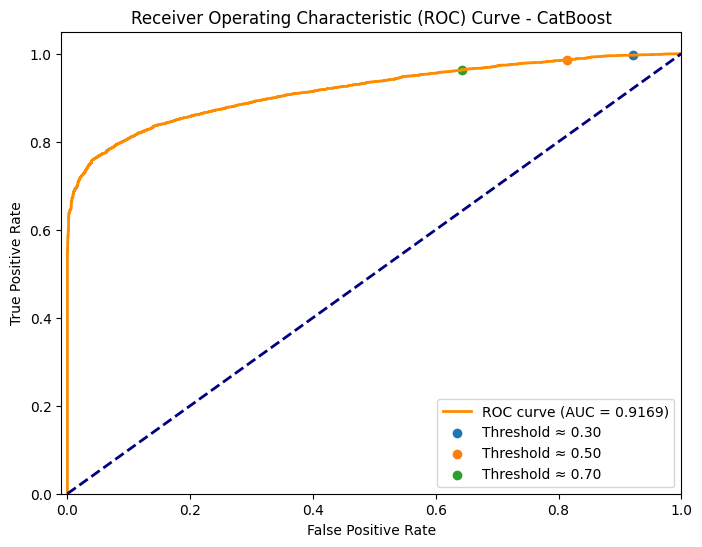


Decision Tree Performance:
              precision    recall  f1-score   support

           0       0.77      0.22      0.34      4424
           1       0.54      0.93      0.69      4392

    accuracy                           0.57      8816
   macro avg       0.65      0.58      0.51      8816
weighted avg       0.65      0.57      0.51      8816



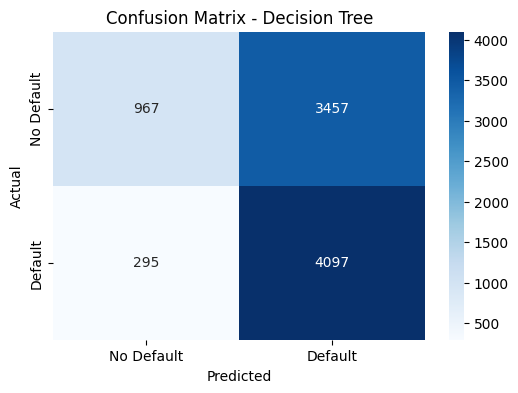

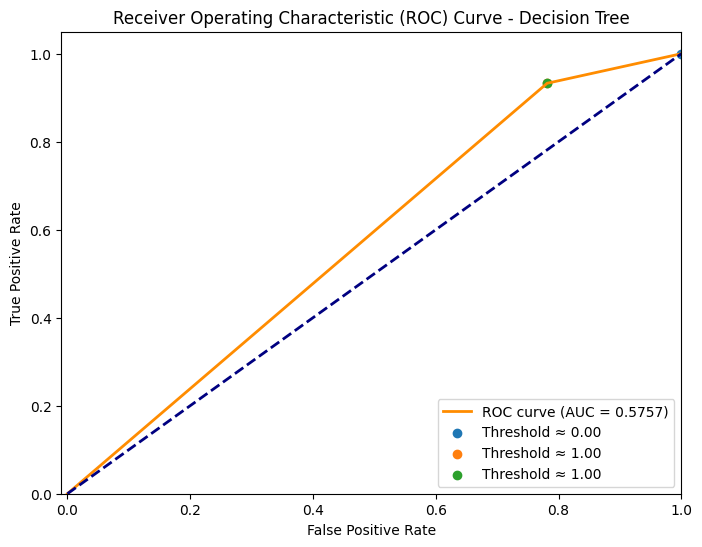


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.94      0.39      0.55      4424
           1       0.61      0.98      0.75      4392

    accuracy                           0.68      8816
   macro avg       0.78      0.68      0.65      8816
weighted avg       0.78      0.68      0.65      8816



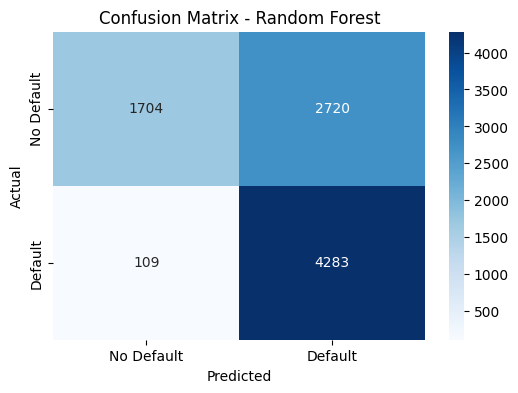

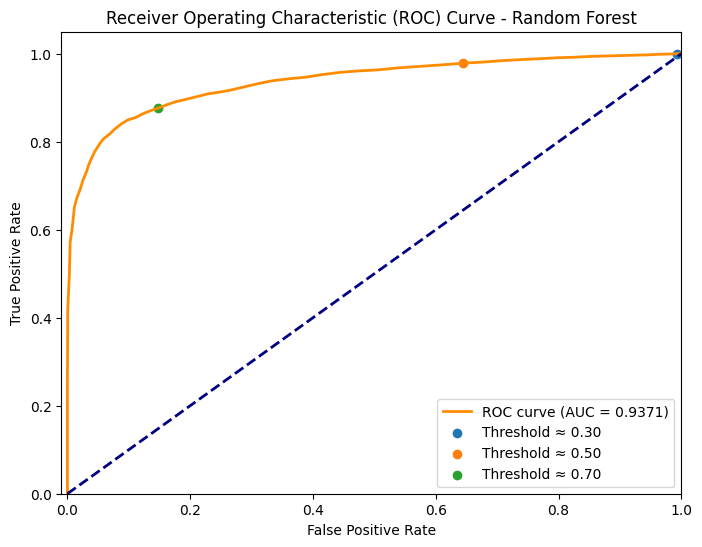

In [ ]:
# Train and evaluate models
results = {}
# plt.figure(figsize=(8, 6))
# standardise before predit. use same procedure > X_test
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred),
        "AUC": roc_auc_score(y_test, y_pred_proba),
        "Train Accuracy": accuracy_score(y_train, model.predict(X_train)),
        "Test Accuracy": accuracy_score(y_test, y_pred),
        "Train AUC": roc_auc_score(y_train, model.predict_proba(X_train)[:, 1]),
        "Test AUC": roc_auc_score(y_test, y_pred_proba)

    }

    print(f"\n{name} Performance:")
    print(classification_report(y_test, y_pred))

    # Generate and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

    # Call function to plot ROC curve
    print("\n")
    plot_roc_curve(y_test, y_pred_proba, name)

# SHAP Analysis

In [ ]:
df_fe_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25770 entries, 0 to 27002
Data columns (total 91 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   loan_amnt                            25770 non-null  float64
 1   annual_inc                           25770 non-null  float64
 2   loan_status                          25770 non-null  int64  
 3   dti                                  25770 non-null  float64
 4   delinq_2yrs                          25770 non-null  int64  
 5   inq_last_6mths                       25770 non-null  int64  
 6   open_acc                             25770 non-null  int64  
 7   pub_rec                              25770 non-null  int64  
 8   revol_bal                            25770 non-null  int64  
 9   revol_util                           25770 non-null  float64
 10  total_acc                            25770 non-null  int64  
 11  out_prncp                        

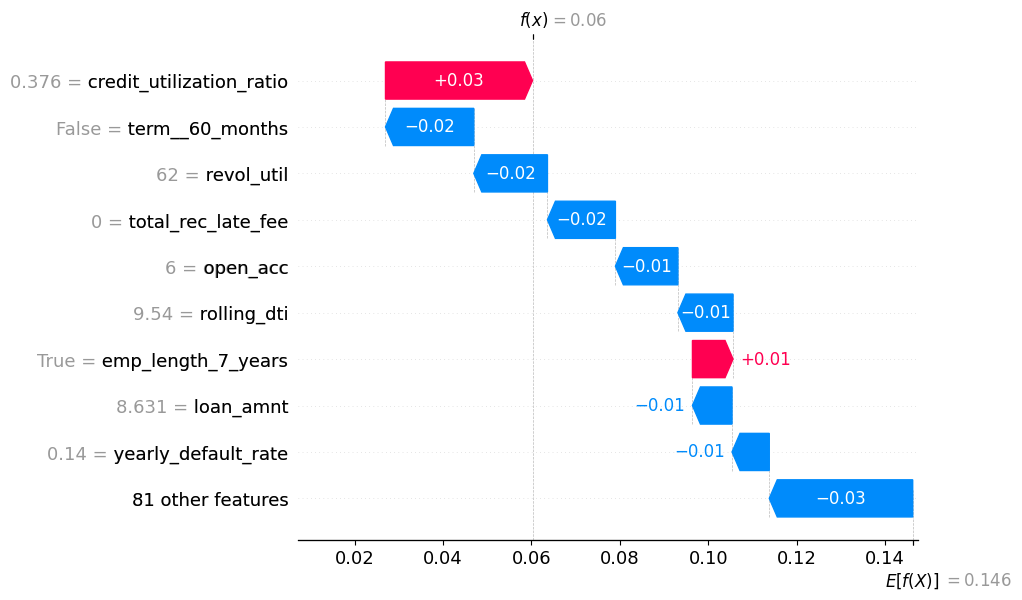

In [ ]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import shap
import pandas as pd
import numpy as np
shap.initjs()

X = df_fe_cleaned.drop("loan_status", axis=1) # Independent variables
y = df_fe_cleaned.loan_status # Dependent variable

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Creating an XGBRegressor model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# Save the XGBoost model in binary format
model.save_model('model.json')

# Load the model from the saved binary file
loaded_model = xgb.XGBRegressor()
loaded_model.load_model('model.json')

# SHAP Explainer
explainer = shap.Explainer(loaded_model)
shap_values = explainer(X_test)

# Initialize the SHAP JavaScript library
shap.initjs()

# Load the model from the saved binary file
loaded_model = xgb.XGBRegressor()
loaded_model.load_model('model.json')

# SHAP Explainer
explainer = shap.Explainer(loaded_model)
shap_values = explainer(X_test)

# Waterfall plot for the first observation
shap.waterfall_plot(shap_values[0])
# eg. this shows direction > terms_60 has neg rel with target. assuming other features r constant

In [ ]:
from pycaret.regression import setup, compare_models, pull, evaluate_model, models

# Set up the PyCaret regression environment.
# Replace 'loan_status' with your actual numeric target variable name.
exp_reg = setup(data=df_fe_cleaned, target='loan_status', session_id=42, normalize=True)

# Display all available regression models.
all_models = models()
print("Available Regression Models in PyCaret:")
print(all_models)

,Description,Value
0,Session id,42
1,Target,loan_status
2,Target type,Regression
3,Original data shape,"(25770, 91)"
4,Transformed data shape,"(25770, 91)"
5,Transformed train set shape,"(18039, 91)"
6,Transformed test set shape,"(7731, 91)"
7,Numeric features,19
8,Preprocess,True
9,Imputation type,simple


Available Regression Models in PyCaret:
                                       Name  \
ID                                            
lr                        Linear Regression   
lasso                      Lasso Regression   
ridge                      Ridge Regression   
en                              Elastic Net   
lar                  Least Angle Regression   
llar           Lasso Least Angle Regression   
omp             Orthogonal Matching Pursuit   
br                           Bayesian Ridge   
ard       Automatic Relevance Determination   
par            Passive Aggressive Regressor   
ransac              Random Sample Consensus   
tr                       TheilSen Regressor   
huber                       Huber Regressor   
kr                             Kernel Ridge   
svm               Support Vector Regression   
knn                   K Neighbors Regressor   
dt                  Decision Tree Regressor   
rf                  Random Forest Regressor   
et                  

### Regression Approach (If the Target is a Continuous Probability)
If your target variable is already a continuous probability (values between 0 and 1), you can use regression models. However, note that many regression models are not inherently bounded, so you might need to clip or calibrate the predictions.

For instance, you can choose models that tend to give stable predictions:

Ridge Regression (ridge): Uses L2 regularization for stable estimates.
Elastic Net (en): Combines L1 and L2 penalties to balance feature selection and shrinkage.
Random Forest Regressor (rf): A robust non-linear model, though you may need to post-process its outputs.
Here’s how you might set this up in PyCaret:

In [ ]:
from pycaret.regression import setup, compare_models, pull, evaluate_model, models
import numpy as np

# [todo] Split is still required. but not need to hanlde mising values, enclding
# Set up the PyCaret regression environment.
exp_reg = setup(data=df_fe_cleaned, target='loan_status', session_id=42, normalize=True)

# Display available regression models.
all_reg_models = models()
print("Available Regression Models in PyCaret:")
print(all_reg_models)

# Compare specific regression models.
selected_reg_models = ['ridge', 'en', 'rf', 'xgboost', 'catboost']
best_reg = compare_models(include=selected_reg_models)



,Description,Value
0,Session id,42
1,Target,loan_status
2,Target type,Regression
3,Original data shape,"(25770, 91)"
4,Transformed data shape,"(25770, 91)"
5,Transformed train set shape,"(18039, 91)"
6,Transformed test set shape,"(7731, 91)"
7,Numeric features,19
8,Preprocess,True
9,Imputation type,simple


Available Regression Models in PyCaret:
                                       Name  \
ID                                            
lr                        Linear Regression   
lasso                      Lasso Regression   
ridge                      Ridge Regression   
en                              Elastic Net   
lar                  Least Angle Regression   
llar           Lasso Least Angle Regression   
omp             Orthogonal Matching Pursuit   
br                           Bayesian Ridge   
ard       Automatic Relevance Determination   
par            Passive Aggressive Regressor   
ransac              Random Sample Consensus   
tr                       TheilSen Regressor   
huber                       Huber Regressor   
kr                             Kernel Ridge   
svm               Support Vector Regression   
knn                   K Neighbors Regressor   
dt                  Decision Tree Regressor   
rf                  Random Forest Regressor   
et                  

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.2129,0.1075,0.3279,0.1220,0.2308,0.7353,5.4990
rf,Random Forest Regressor,0.2213,0.1102,0.3320,0.1001,0.2359,0.7232,17.3750
ridge,Ridge Regression,0.2247,0.1120,0.3346,0.0857,0.2346,0.7785,0.5670
xgboost,Extreme Gradient Boosting,0.2190,0.1155,0.3398,0.0568,0.2404,0.7306,0.4980
en,Elastic Net,0.2452,0.1226,0.3501,-0.0006,0.2452,0.8569,0.1040


Processing:   0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:

# Retrieve and display the results.
results_df = pull()
print("Comparison of Selected Regression Model Results:")
print(results_df)

# Evaluate the best regressor.
evaluate_model(best_reg)

#For new data predictions:
# prob_predictions = best_reg.predict(new_data)
# Ensure predictions lie between 0 and 1, then convert to percentage:
# prob_predictions = np.clip(prob_predictions, 0, 1) * 100

Comparison of Selected Regression Model Results:
                              Model     MAE     MSE    RMSE      R2   RMSLE  \
catboost         CatBoost Regressor  0.2129  0.1075  0.3279  0.1220  0.2308   
rf          Random Forest Regressor  0.2213  0.1102  0.3320  0.1001  0.2359   
ridge              Ridge Regression  0.2247  0.1120  0.3346  0.0857  0.2346   
xgboost   Extreme Gradient Boosting  0.2190  0.1155  0.3398  0.0568  0.2404   
en                      Elastic Net  0.2452  0.1226  0.3501 -0.0006  0.2452   

            MAPE  TT (Sec)  
catboost  0.7353     5.499  
rf        0.7232    17.375  
ridge     0.7785     0.567  
xgboost   0.7306     0.498  
en        0.8569     0.104  


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

# SHAP Classification Report

For better interpretability

In [ ]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import shap
import pandas as pd
import numpy as np
shap.initjs()

X = df_fe_cleaned.drop("loan_status", axis=1) # Independent variables
y = df_fe_cleaned.loan_status # Dependent variable

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Train a machine learning model Gradient Boosting (best model)
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)

# Make prediction on the testing data
y_pred = clf.predict(X_test)

# Classification Report
print(classification_report(y_pred, y_test))

explainer = shap.Explainer(clf)
shap_values = explainer.shap_values(X_test)

              precision    recall  f1-score   support

           0       1.00      0.87      0.93      7585
           1       0.10      0.78      0.18       146

    accuracy                           0.87      7731
   macro avg       0.55      0.83      0.56      7731
weighted avg       0.98      0.87      0.92      7731



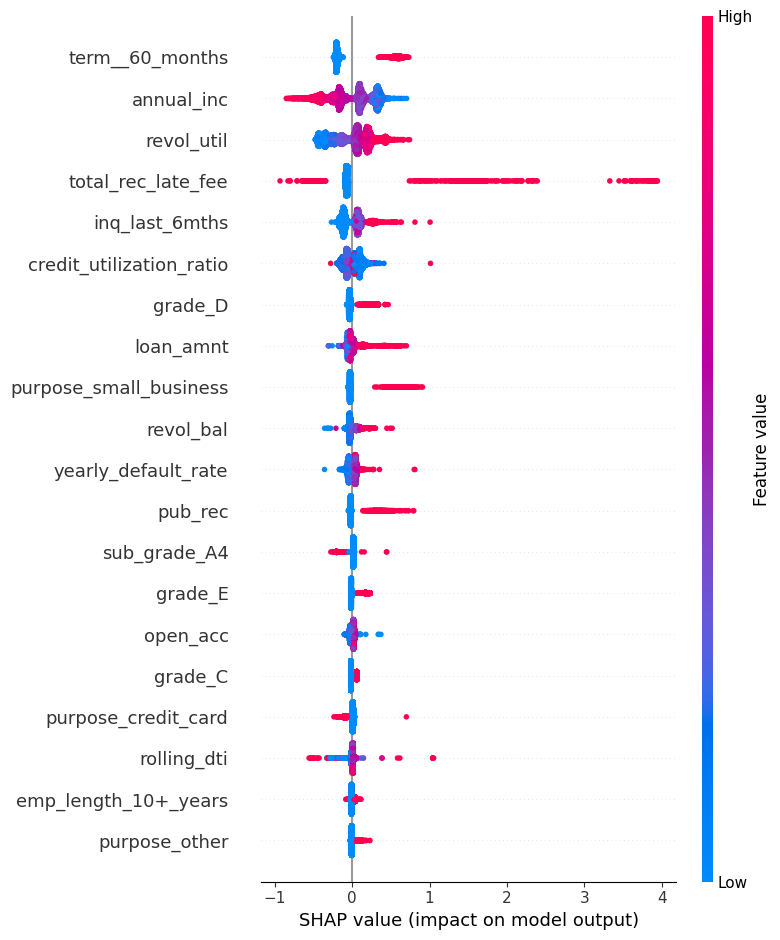

In [ ]:
shap.summary_plot(shap_values, X_test)

In [ ]:
# Next steps
# Go beyond numbers
# Give concret examples -> apply to real usecase -> eg based on client profile -> predict values from diff models -> explain which model performs well under which conditions
# data -> predict -> analyse the models -> what can go wrong etc
# interpret and go deep into insights
# model part can be imperfect but ok